In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Looking for ETVs in TIC 57297550


In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid = 57297550  # EW, only 2 sectors of 2min data, 2 sectors of TESS-SPOC (10min)

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
lc_tess = sr.download_all().stitch()
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 4 data products.

 #     mission     year   author  exptime target_name distance proposal_id
                                     s                 arcsec             
--- -------------- ---- --------- ------- ----------- -------- -----------
  0 TESS Sector 24 2020      SPOC     120    57297550      0.0     G022062
  1 TESS Sector 25 2020      SPOC     120    57297550      0.0     G022062
  2 TESS Sector 51 2022 TESS-SPOC     600    57297550      0.0         N/A
  3 TESS Sector 52 2022 TESS-SPOC     600    57297550      0.0         N/A

42040

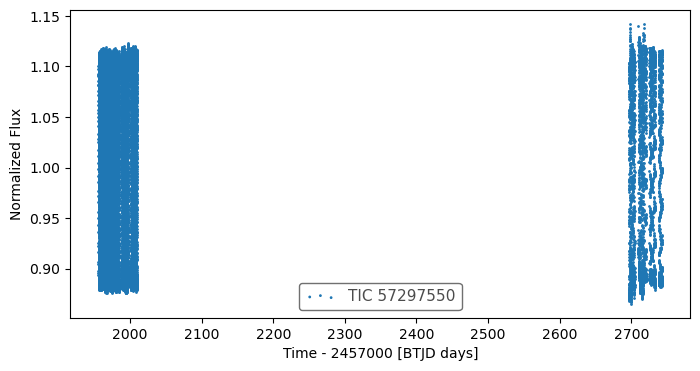

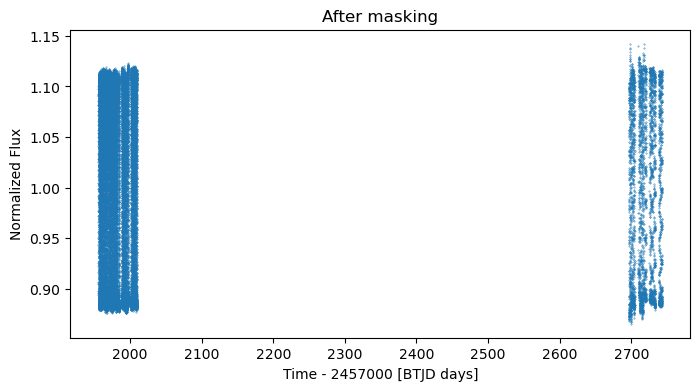

In [5]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

# mask = time < 0 #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  
mask = flux < 0.85    # remove occassional outliers

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [6]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [7]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

In [8]:
round(0.1911155958357545 * 2, 7)

0.3822312

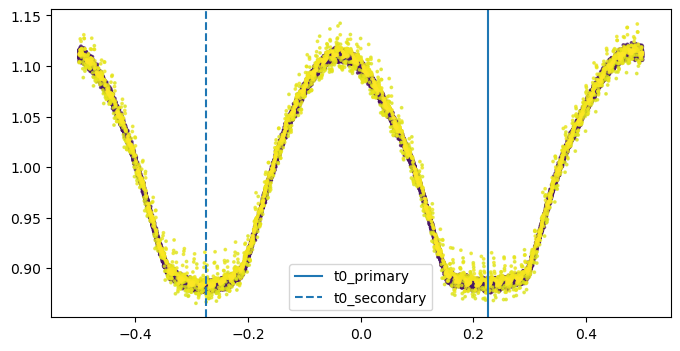

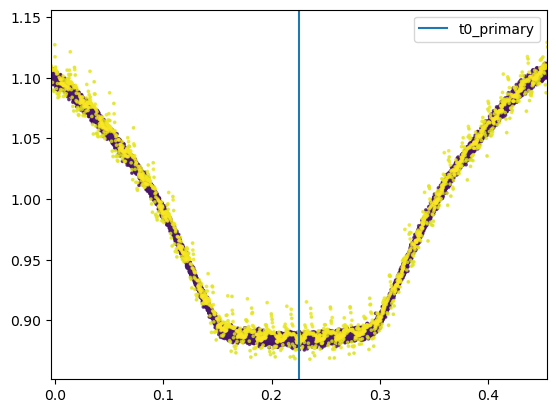

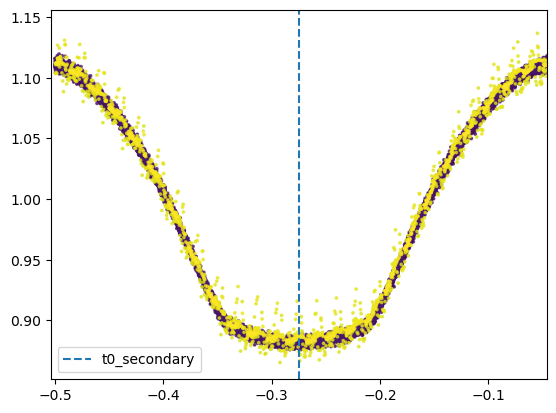

In [41]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# epoch=1955.9687, duration_hr=3.5355, period=0.382169, label="s0014-s0026:TCE1",

# FILL-IN THE eclipse epoch / period, 
# period = 0.3822312  # LombScargle result X 2, 6 decimal looks sufficient, add 1 more  # TCE: 0.382169  # VSX: 0.38222952  # LombScargle (oversample_factor=50): 0.1911155958357545 -0.0086909	+0.0087116	
# period = 0.382231 # MCMC result (wider window for clipped LC) 0.3822306257941068, it is close to as LombScarlge result adopted
period = 0.38223062 # MCMC result (narrower window for clipped LC) 0.3822306206806438  # std_p: 3.6181550292552573e-09


t0_primary = 1955.9687 - 0.002  # TCE1, with manual offset
t0_secondary = t0_primary + period / 2


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 3.5
duration_hr_secondary = duration_hr_primary

# t0_for_plotting = 0  # keep 0 for plotting purposes
t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [9]:
# show data to visualize what's changed in each step below
data  

time      flux       err     phase
0      1955.797846  0.893337  0.001476 -0.221990
1      1955.799235  0.895806  0.001478 -0.218356
2      1955.800624  0.897869  0.001481 -0.214723
3      1955.802013  0.904357  0.001480 -0.211089
4      1955.803402  0.906119  0.001481 -0.207455
...            ...       ...       ...       ...
34965  2743.047832  1.066002  0.000571  0.395293
34966  2743.054777  1.085950  0.000575  0.413461
34967  2743.061721  1.101182  0.000578  0.431629
34968  2743.068665  1.111649  0.000581  0.449797
34969  2743.075610  1.116295  0.000581  0.467965

[34970 rows x 4 columns]

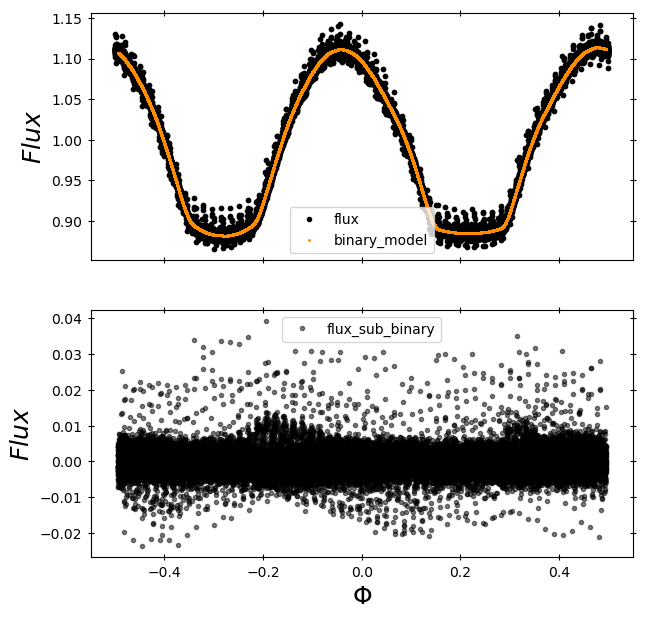

time      flux       err     phase  flux_sub_binary  \
0      1955.797846  0.893337  0.001476 -0.221990        -0.001381   
1      1955.799235  0.895806  0.001478 -0.218356        -0.001313   
2      1955.800624  0.897869  0.001481 -0.214723        -0.002283   
3      1955.802013  0.904357  0.001480 -0.211089        -0.000119   
4      1955.803402  0.906119  0.001481 -0.207455        -0.003867   
...            ...       ...       ...       ...              ...   
34965  2743.047832  1.066002  0.000571  0.395293         0.004919   
34966  2743.054777  1.085950  0.000575  0.413461         0.006234   
34967  2743.061721  1.101182  0.000578  0.431629         0.005774   
34968  2743.068665  1.111649  0.000581  0.449797         0.004871   
34969  2743.075610  1.116295  0.000581  0.467965         0.003533   

       binary_model  
0          0.894719  
1          0.897119  
2          0.900151  
3          0.904476  
4          0.909986  
...             ...  
34965      1.061083  
34966      1.079717  
34967      1.095408  
34968      1.106778  
34969      1.112762  

[34970 rows x 6 columns]

In [10]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

10 34624 901
reached the end
10 33270 901
reached the end
10 33090 901
reached the end
10 33052 901
reached the end
10 33042 901
reached the end


time      flux       err     phase  flux_sub_binary  \
0      1955.797846  0.893337  0.001476 -0.221990        -0.001381   
1      1955.799235  0.895806  0.001478 -0.218356        -0.001313   
2      1955.800624  0.897869  0.001481 -0.214723        -0.002283   
3      1955.802013  0.904357  0.001480 -0.211089        -0.000119   
4      1955.803402  0.906119  0.001481 -0.207455        -0.003867   
...            ...       ...       ...       ...              ...   
34965  2743.047832  1.066002  0.000571  0.395293         0.004919   
34966  2743.054777  1.085950  0.000575  0.413461         0.006234   
34967  2743.061721  1.101182  0.000578  0.431629         0.005774   
34968  2743.068665  1.111649  0.000581  0.449797         0.004871   
34969  2743.075610  1.116295  0.000581  0.467965         0.003533   

       binary_model  flux_detrended  
0          0.894719        0.894733  
1          0.897119        0.897204  
2          0.900151        0.899269  
3          0.904476        0.905759  
4          0.909986        0.907523  
...             ...             ...  
34965      1.061083        1.060239  
34966      1.079717        1.080173  
34967      1.095408        1.095389  
34968      1.106778        1.105841  
34969      1.112762        1.110473  

[34970 rows x 7 columns]

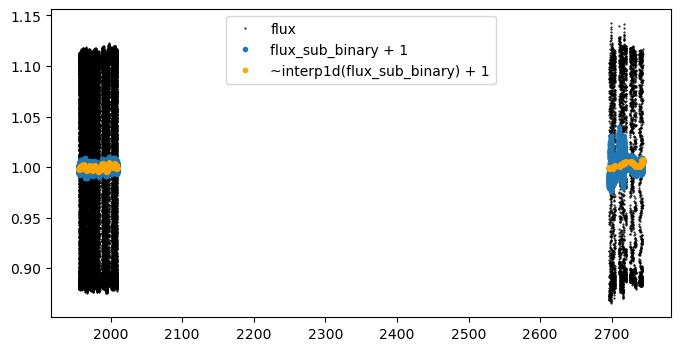

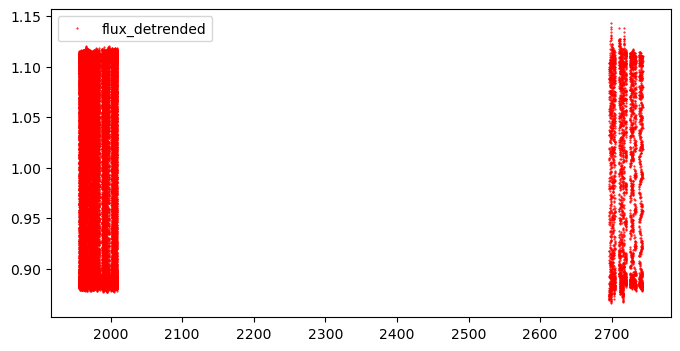

In [11]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

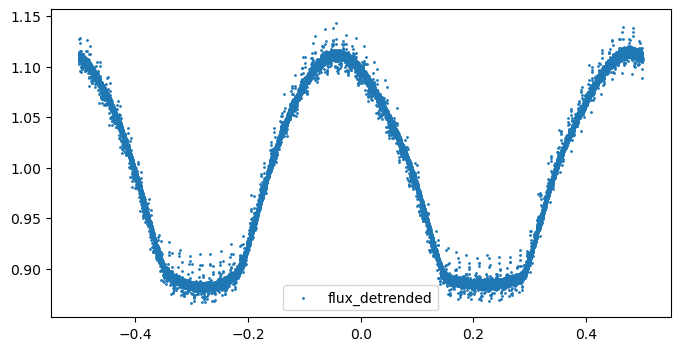

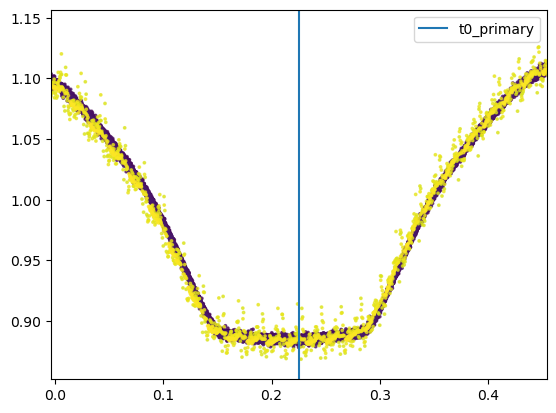

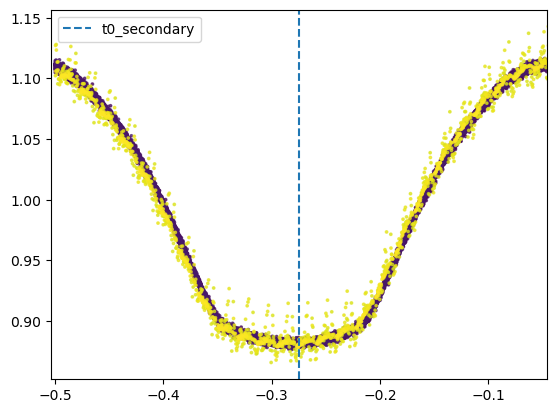

In [12]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1, label="flux_detrended")
plt.legend()
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

### Now that the data is ready we can start 

In [43]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 0.8 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 0.8 * duration_hr_secondary / 24 / period  
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
# start_vals = [1.073, -0.189, midpoint_p, 0.081, 2.108]
# start_vals_s = [1.09, -0.20, midpoint_s, 0.09, 1.5]
start_vals = [1.041, -0.1558, midpoint_p, 0.06838, 2.996]
start_vals_s = [1.067, -0.1838, midpoint_s, 0.0737, 2.146]
# mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0415498022179395, -0.15582011873312712, 0.21668018101899994, 0.06838310737963611, 2.9967923028290775
# mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.067636483758358, -0.18375187552981442, -0.28289859475537815, 0.07373352849495765, 2.14629291775017

# -- -- -- -- -- -- -- -- --
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, t0_primary, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   1955.9667 0.22500000000010312
window_width_p (phase): 0.3052258520436345
Secondary: 1956.15781531 -0.2749999999999323
window_width_s (phase): 0.3052258520436345


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Start params for  fitting period with MCMC on df_primary:
[1.041, -0.1558, t0_primary, 0.06838, 2.996, 0.38223062],


In [ ]:
if False: 
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [04:42<00:00,  3.54it/s]


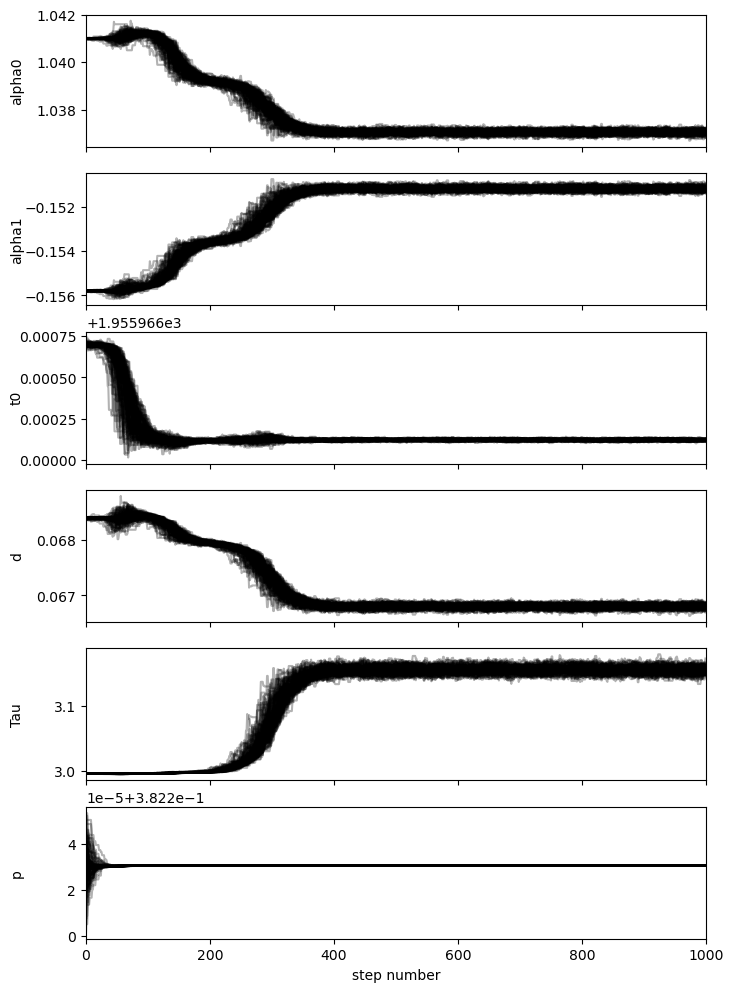

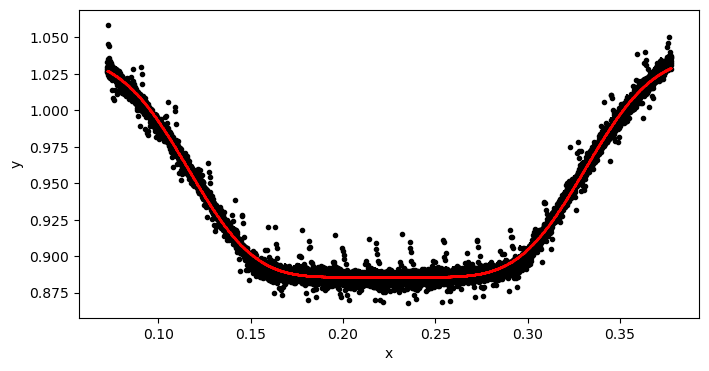

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0370569885640046, -0.1511767506449168, 1955.9661197322903, 0.06680280683950482, 3.15485142789863, 0.3822306248790066
std_p: 3.7192862210782274e-09


In [80]:
# use MCMC to refine the period

use_mcmc_to_fit_period = True

from importlib import reload
reload(etv_functions)
reload(etvp)

if use_mcmc_to_fit_period:
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1.041, -0.1558, t0_primary, 0.06838, 2.996, 0.38223062],
        nruns=1000, discard=600, 
        # nruns=20, discard=1, 
        pool=4,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"])


#### Illustrating the broken refactored `run_mcmc_initial_fit_p()`

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [03:57<00:00,  4.22it/s]


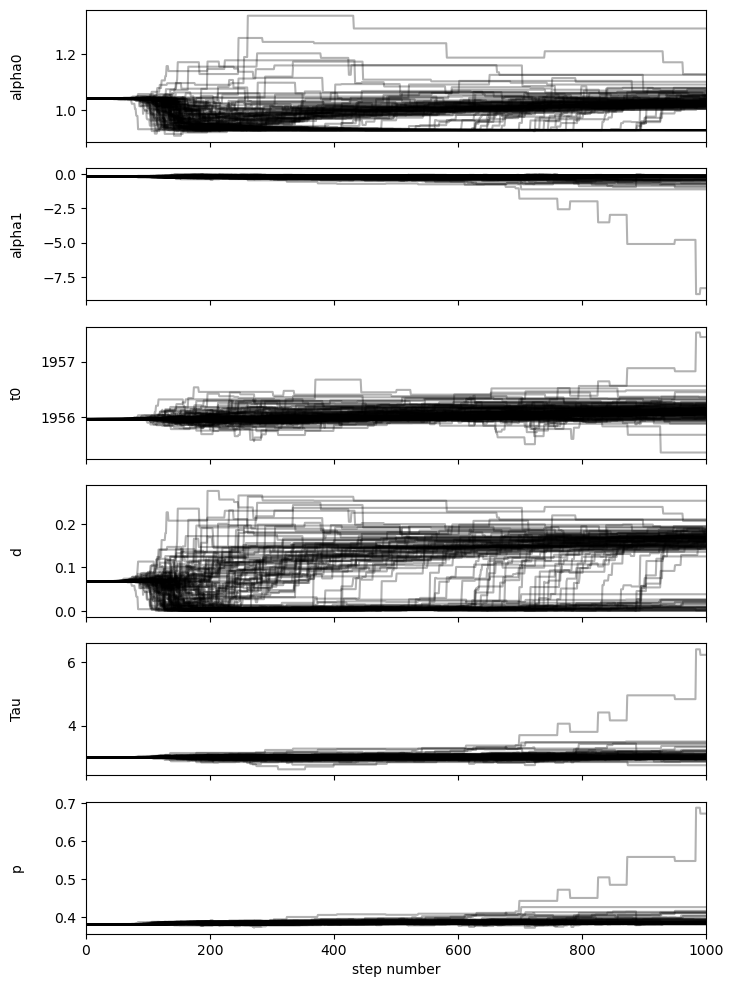

C:\dev\_juypter\PH_TESS_LightCurveViewer\eb_with_diff_sb_period\etv\etv_functions_with_period.py:209: RuntimeWarning: overflow encountered in cosh


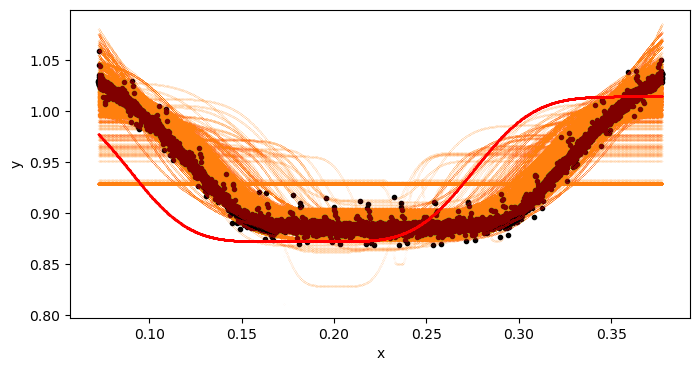

(1.0143935146231884, -0.1423412186311219, 1956.0868584277778, 0.1519221748840567, 3.000615981182768, 0.3854758706573711, {'std_alpha0': 0.05715014002009855, 'std_alpha1': 0.3357187993314947, 'std_t0': 0.1312669882091948, 'std_d': 0.06903784684204585, 'std_Tau': 0.15062098541883134, 'std_p': 0.012141294084779538})


In [82]:
from importlib import reload
reload(etv_functions)
reload(etvp)

# TODO: the refactored implementation behaves differently and covnerges poorly. Root cause unknown. So its use is on hold.
print(
    etvp.x_new_broken_run_mcmc_initial_fit_p(
        data_primary[:],
        [1.041, -0.1558, t0_primary, 0.06838, 2.996, 0.38223062],
        nruns=1000, discard=600, 
        # nruns=20, discard=1, 
        pool=4,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
)

DBG1 log_prob_func: <function log_probability at 0x0000019CC6ABDD80>  ; start_vals: [1.041, -0.1558, 0.22500000000010312, 0.06838, 2.996]
DBG2 log_prob_func(start_vals) -57889606.77868429


100%|██████████████████████████████████████████████████████████| 1000/1000 [03:51<00:00,  4.32it/s]


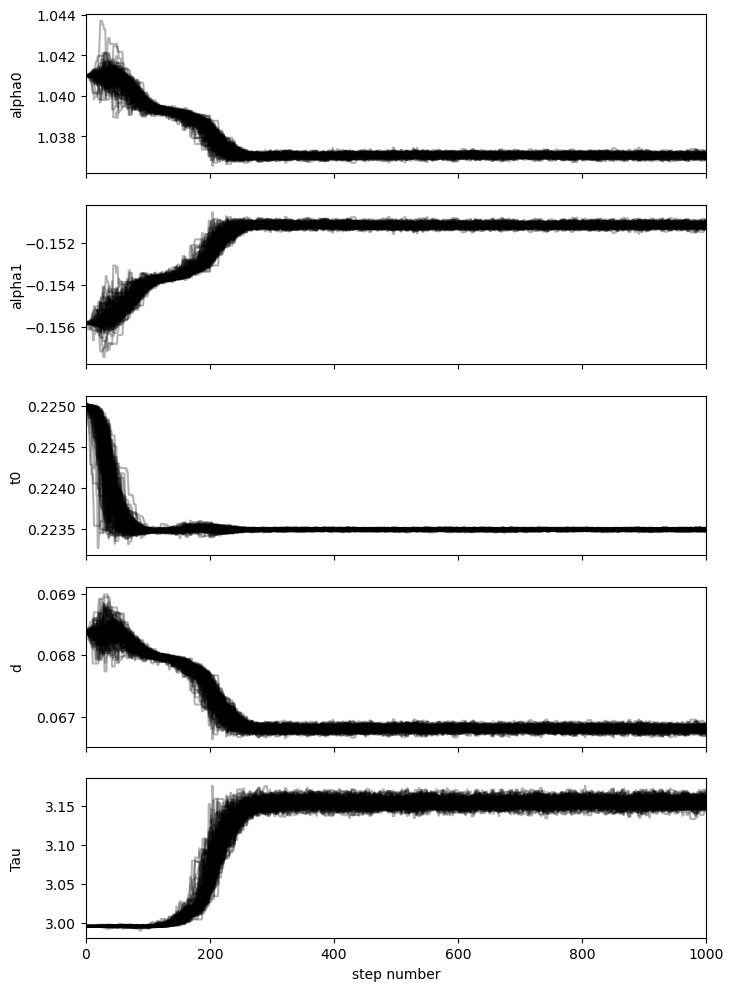

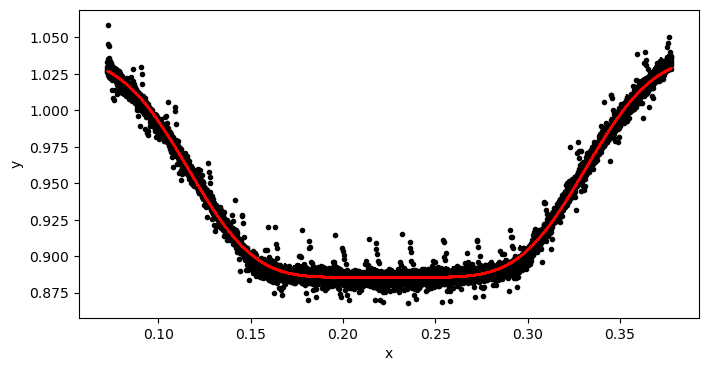

DBG1 log_prob_func: <function log_probability at 0x0000019CC6ABDD80>  ; start_vals: [1.067, -0.1838, -0.2749999999999323, 0.0737, 2.146]
DBG2 log_prob_func(start_vals) -77291219.00311667


100%|██████████████████████████████████████████████████████████| 1000/1000 [03:58<00:00,  4.20it/s]


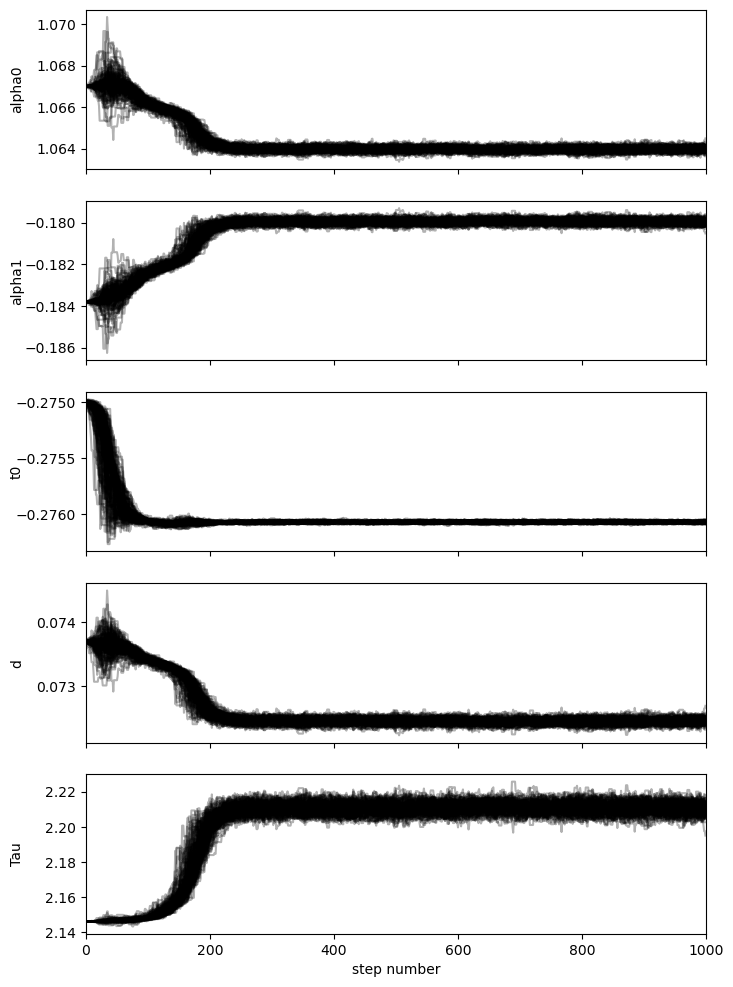

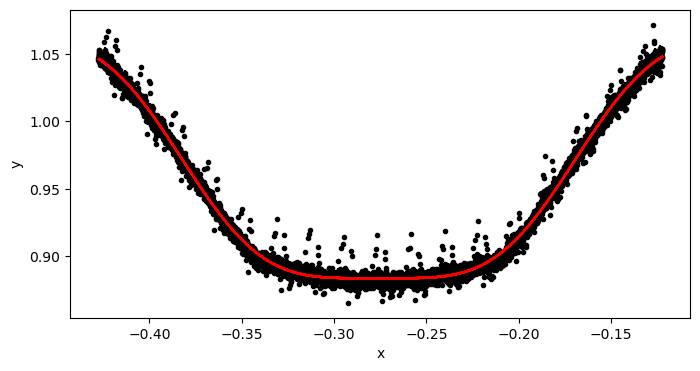

In [51]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, plot_chains = True, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, plot_chains = True, plot = True)
    !$NOTIFY_CMD "Initial fit done"

Use pre-defined inital model params:


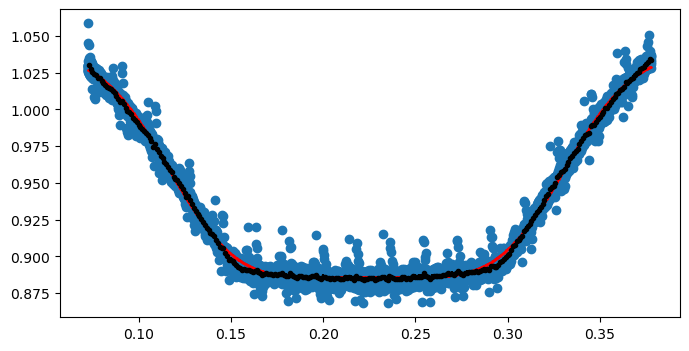

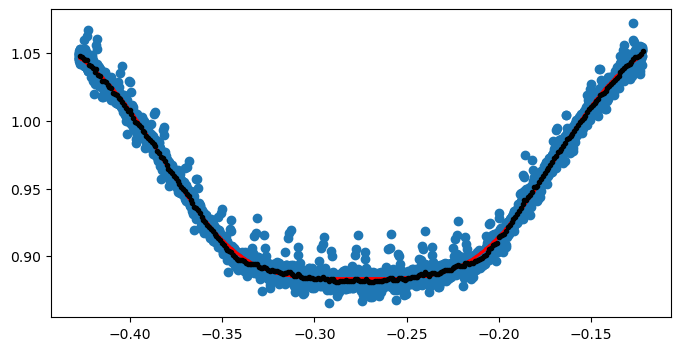

In [49]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data, with wider clipped LC window
    # mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0733060735771711, -0.1891585144165238, 0.2165254598082374, 0.08145869672237488, 2.1059379603318096
    # mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0947691932283237, -0.21229417277560728, -0.28284599880306965, 0.08395793189313172, 1.7447910963848927
    # with narrower clipped LC window
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.037057578463065, -0.15117536481990043, 0.22349469631733843, 0.06680325545581753, 3.15482248519485
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0639617979416593, -0.17993873081408018, -0.2760700374536662, 0.07244035984802011, 2.210924984964066

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])

    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [52]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.037057578463065, -0.15117536481990043, 0.22349469631733843, 0.06680325545581753, 3.15482248519485
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0639617979416593, -0.17993873081408018, -0.2760700374536662, 0.07244035984802011, 2.210924984964066


2059

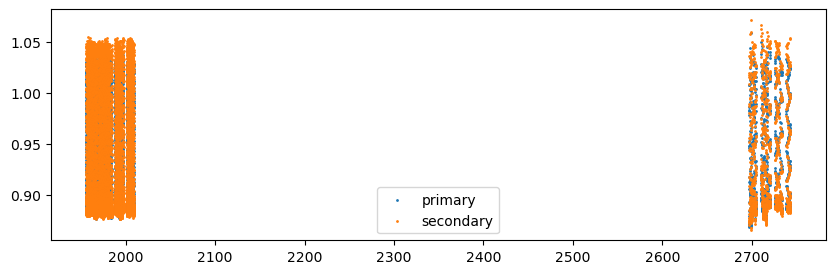

In [53]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1955.9667 0.38223062 1955.9667


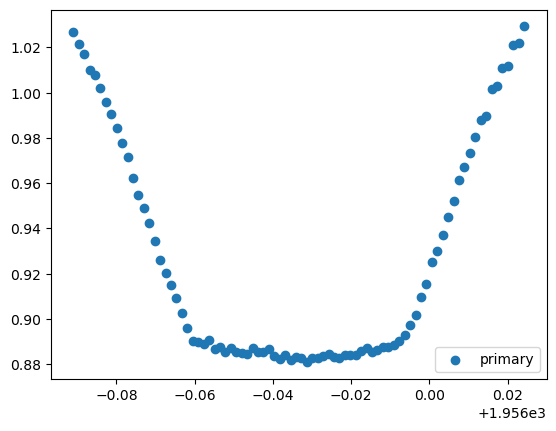

1955.9667 0.38223062 1956.34893062


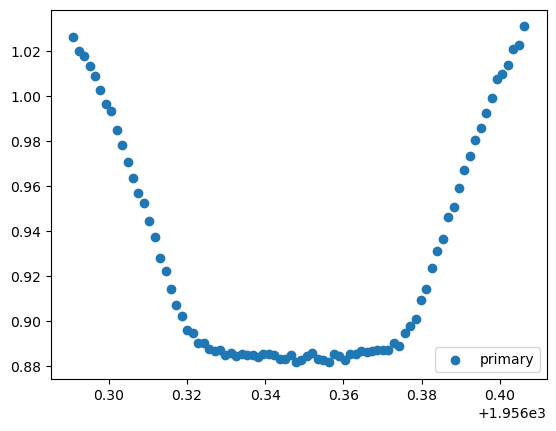

1955.9667 0.38223062 1956.73116124


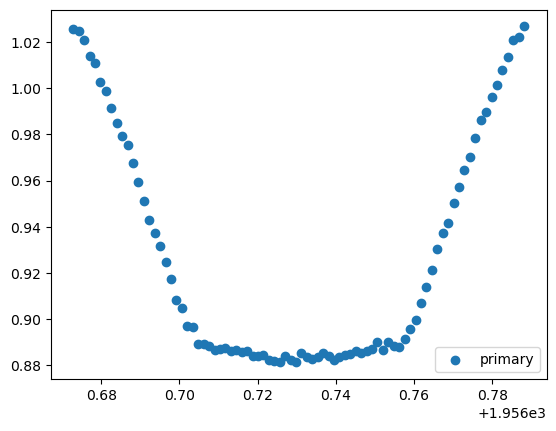

1956.15781531 0.38223062 1956.15781531


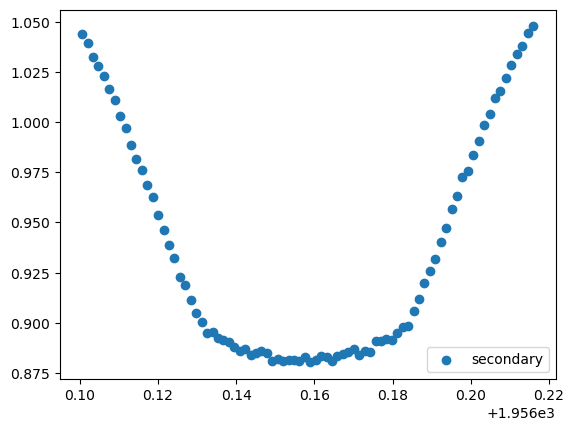

1956.15781531 0.38223062 1956.54004593


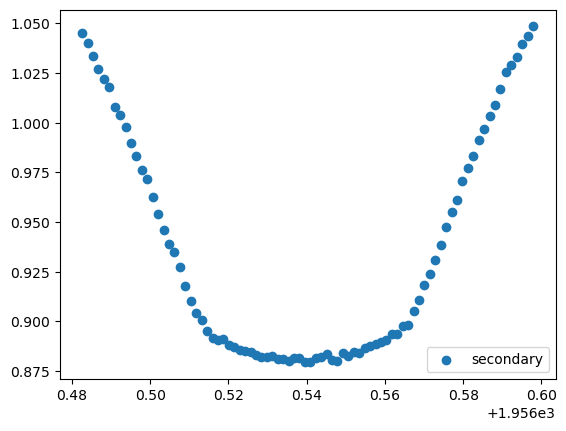

1956.15781531 0.38223062 1956.9222765499999


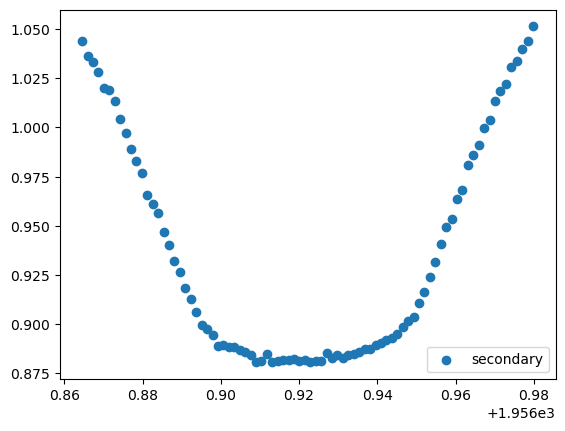

In [54]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Number 3 has already been completed -- skip
Number 4 has already been completed -- skip
Number 5 has already been completed -- skip
Number 6 has already been completed -- skip
Number 7 has already been completed -- skip
Number 8 has already been completed -- skip
Number 9 has already been completed -- skip
Number 10 has already been completed -- skip
Number 11 has already been completed -- skip
Number 12 has already been completed -- skip
Number 13 has already been completed -- skip
Number 14 has already been completed -- skip
Number 15 has already been completed -- skip
Number 16 has already been completed -- skip
Number 17 has already been completed -- skip
Number 18 has already been completed -- skip
Number 19 has al

100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.15it/s]


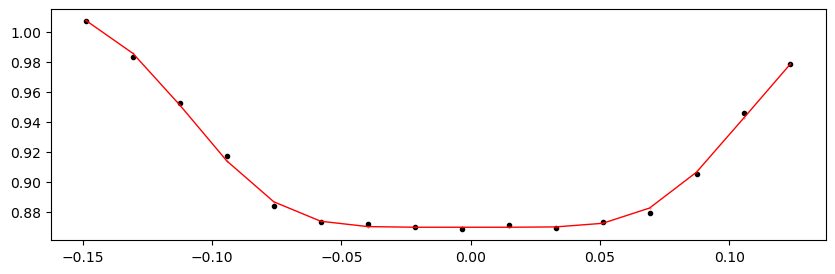

Time 2697.11187218 does not have enough data points: 2
2697.4941028 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.28it/s]


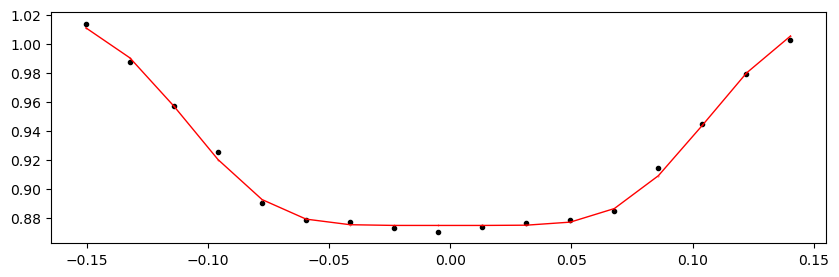

2697.8763334200003 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.08it/s]


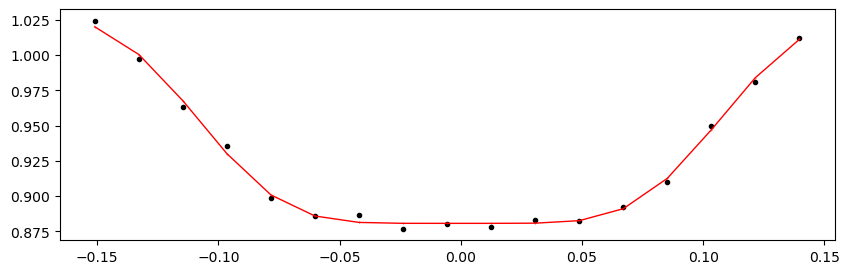

2698.2585640400002 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.21it/s]


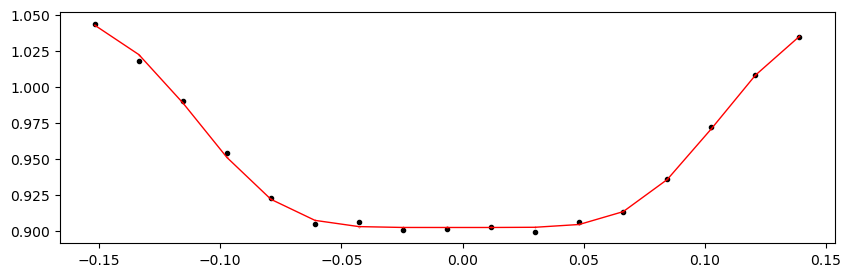

2698.64079466 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.95it/s]


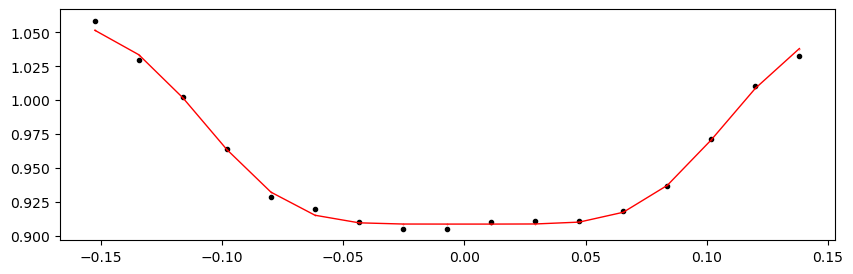

2699.02302528 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.89it/s]


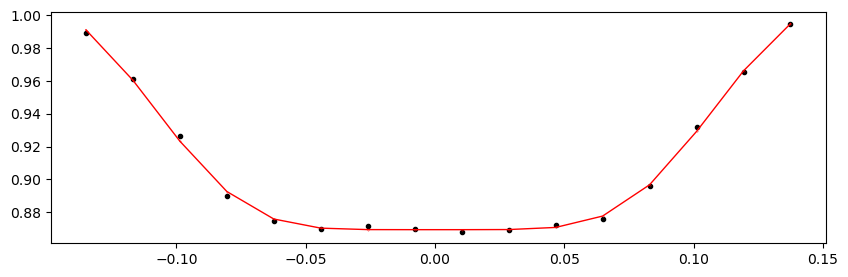

2699.4052559 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.25it/s]


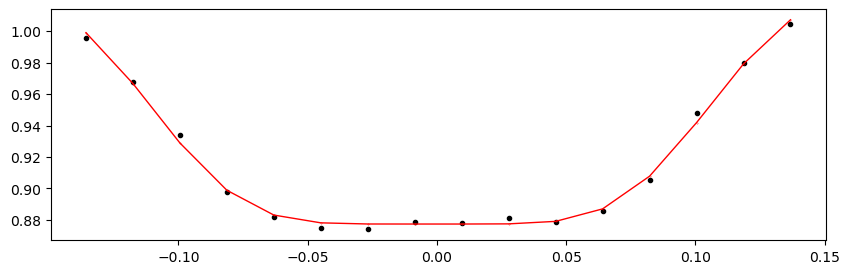

2699.78748652 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.10it/s]


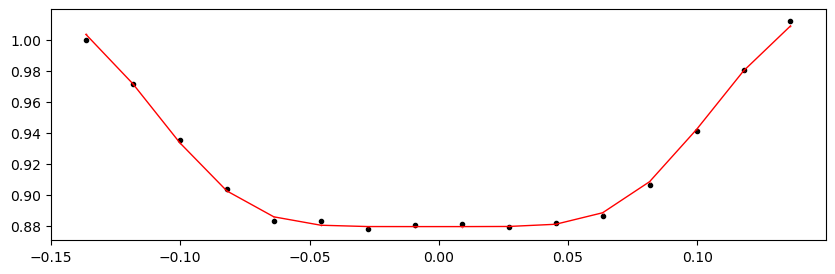

2700.16971714 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.11it/s]


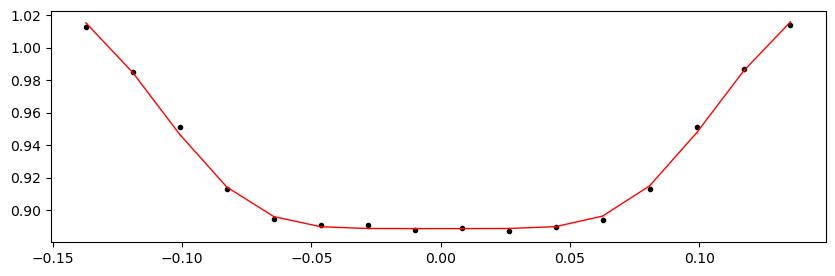

2700.55194776 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.09it/s]


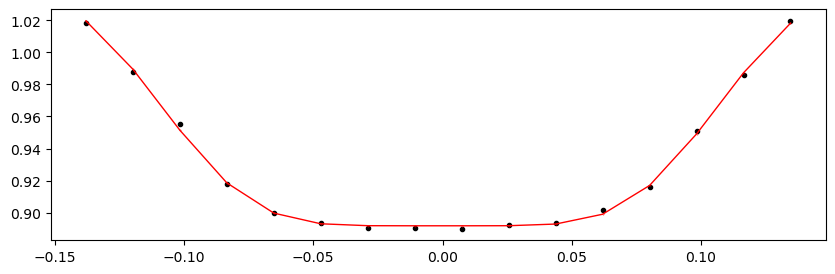

2700.93417838 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.49it/s]


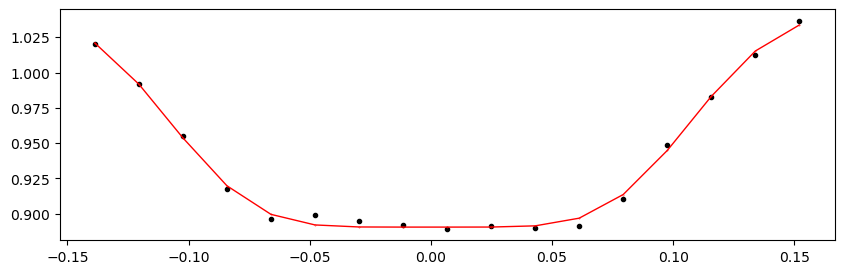

2701.316409 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.94it/s]


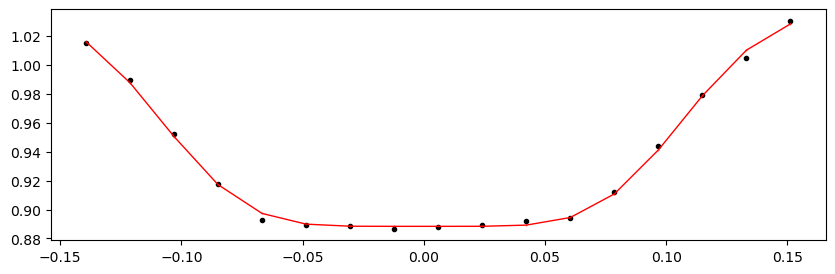

2701.69863962 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.22it/s]


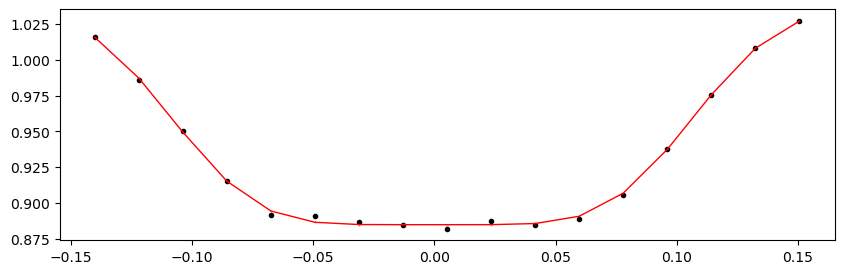

2702.08087024 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.36it/s]


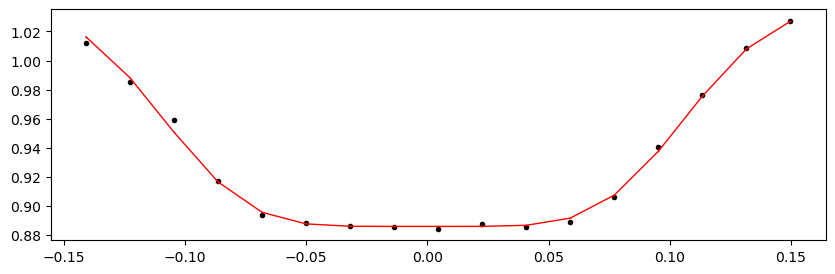

2702.46310086 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.94it/s]


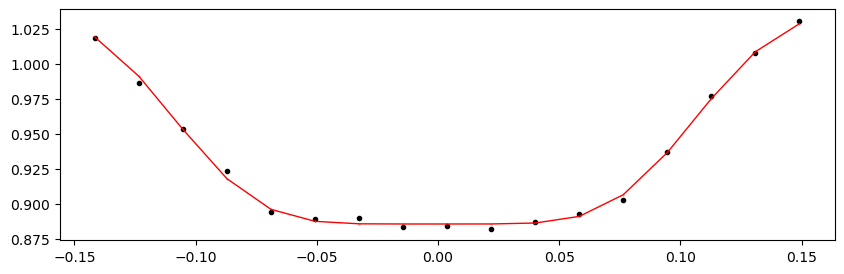

2702.84533148 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.96it/s]


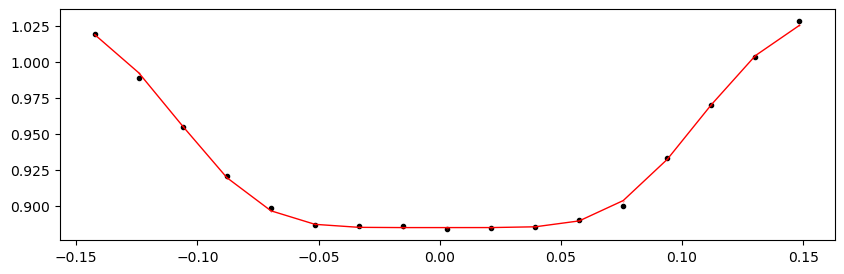

2703.2275621 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.66it/s]


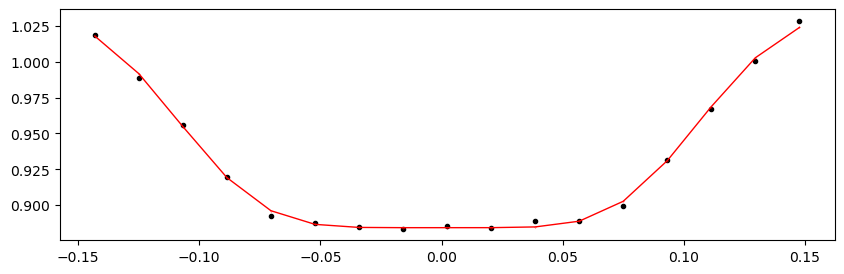

2703.60979272 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.56it/s]


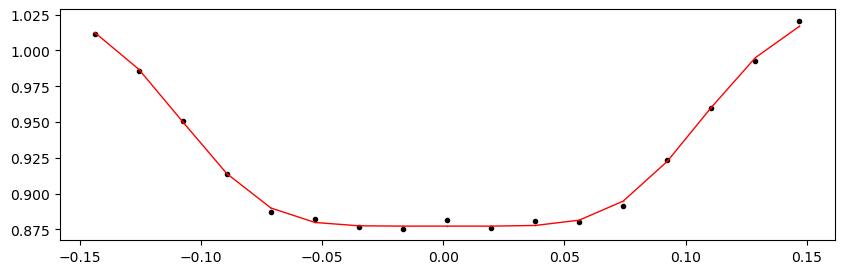

2703.99202334 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.27it/s]


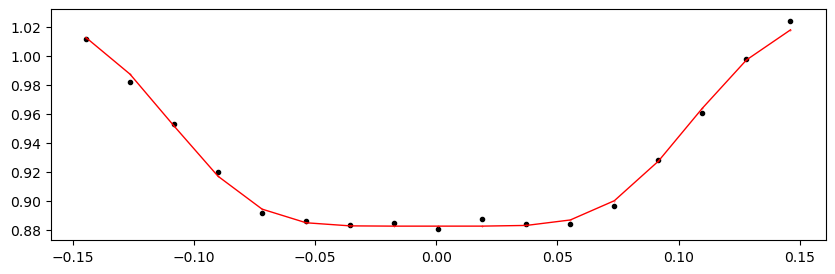

2704.37425396 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.13it/s]


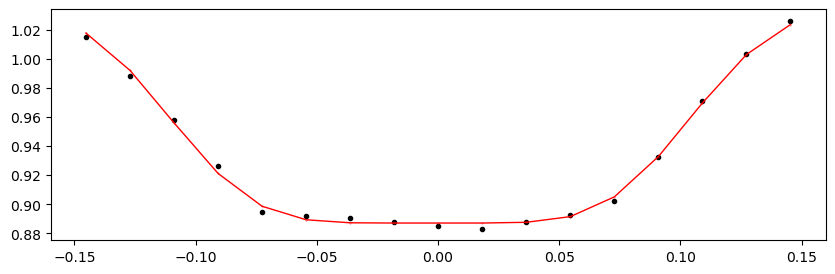

Time 2710.10771326 does not have enough data points: 10
2710.48994388 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.97it/s]


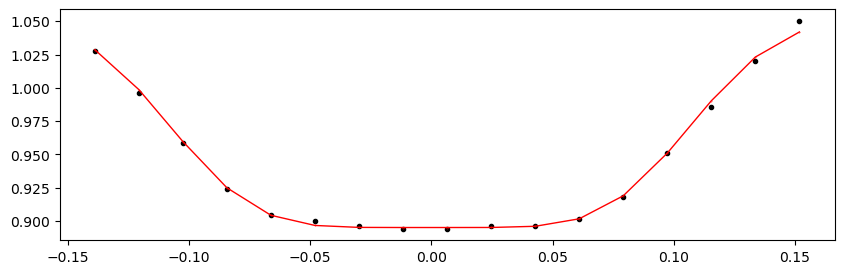

2710.8721745000003 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.85it/s]


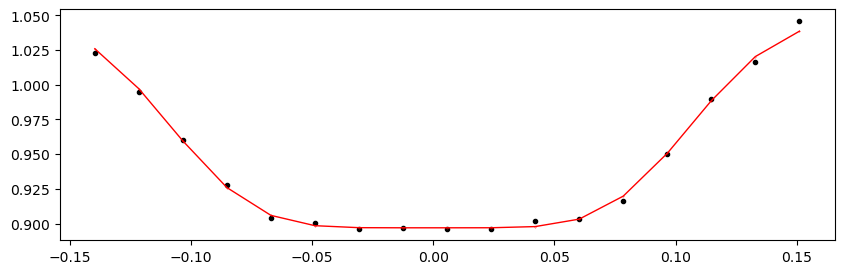

2711.2544051200002 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.29it/s]


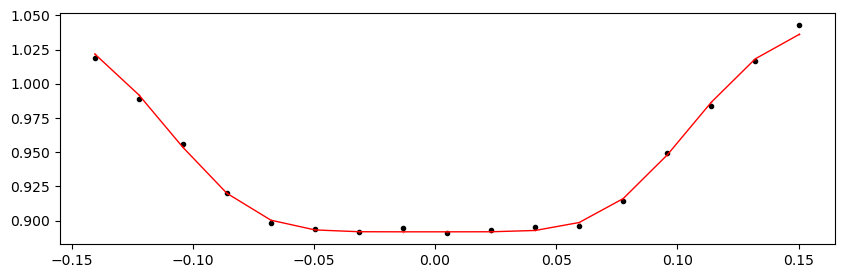

Time 2711.63663574 does not have enough data points: 14
2712.01886636 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.67it/s]


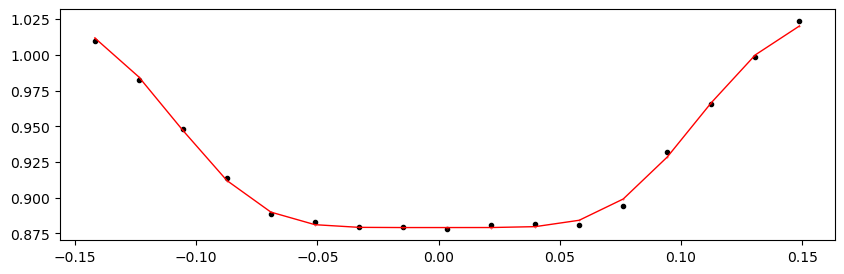

2712.40109698 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.27it/s]


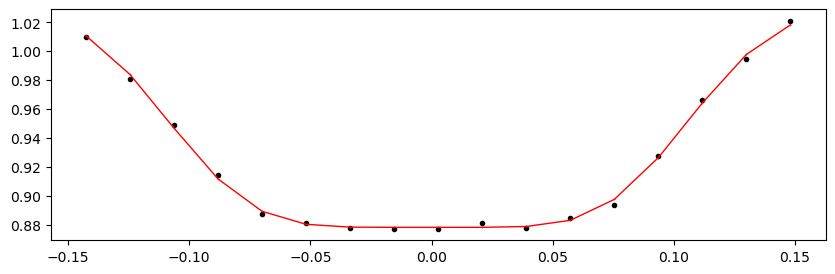

2712.7833276 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.61it/s]


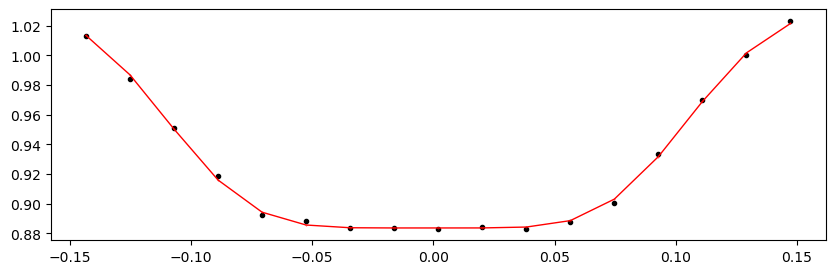

2713.16555822 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.30it/s]


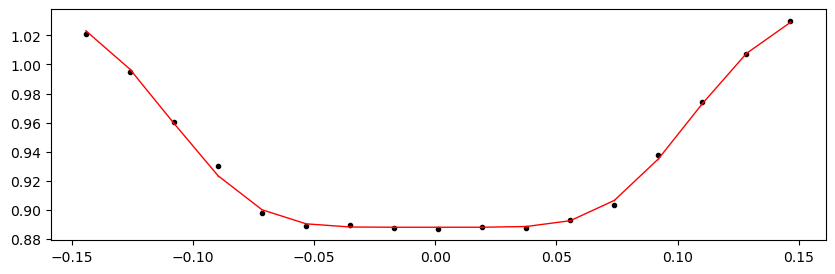

2713.54778884 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.85it/s]


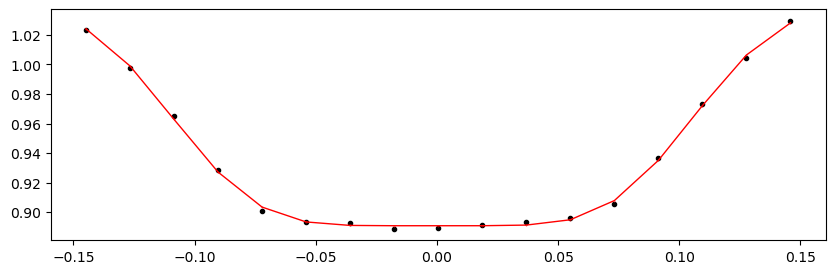

2713.93001946 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.08it/s]


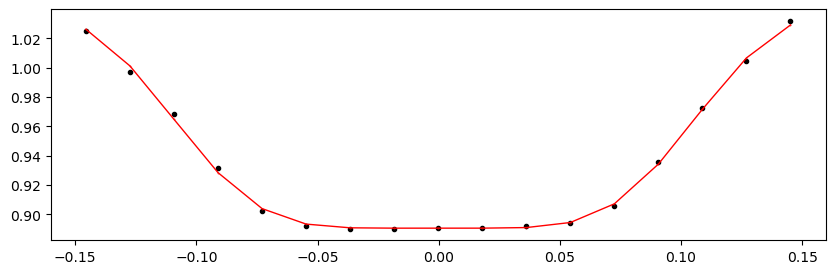

2714.31225008 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.79it/s]


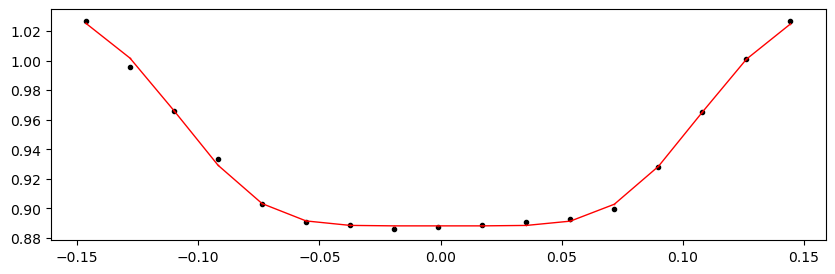

2714.6944807 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.45it/s]


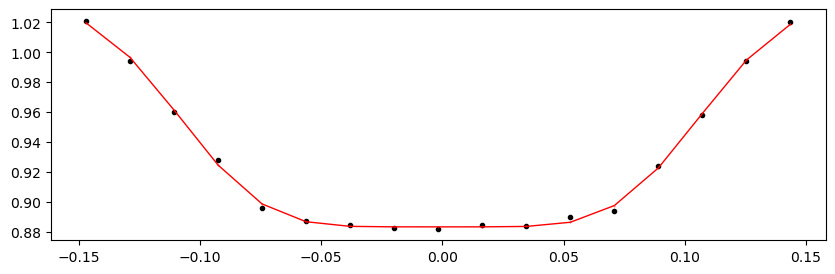

2715.07671132 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.86it/s]


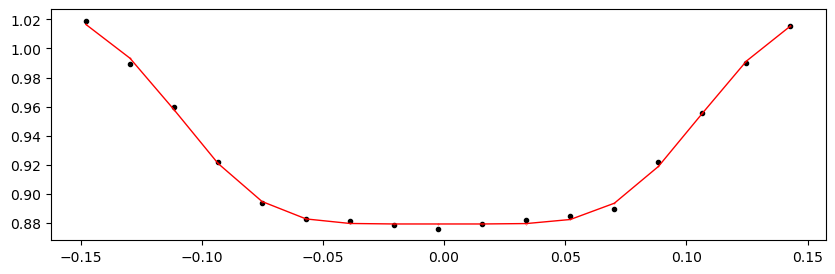

2715.45894194 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.78it/s]


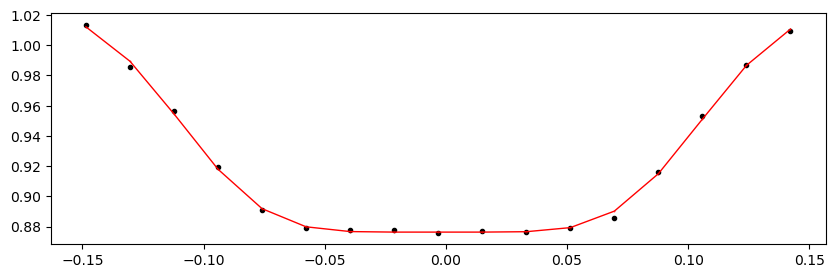

2715.84117256 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.48it/s]


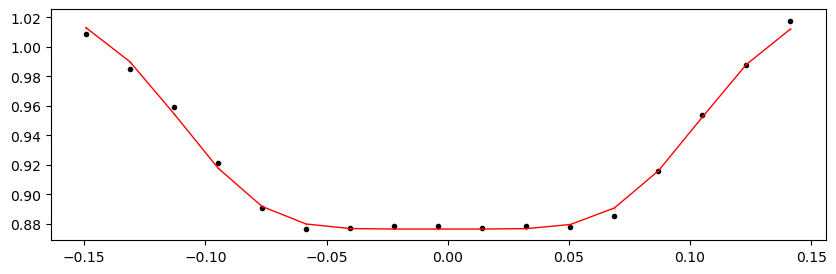

2716.22340318 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.97it/s]


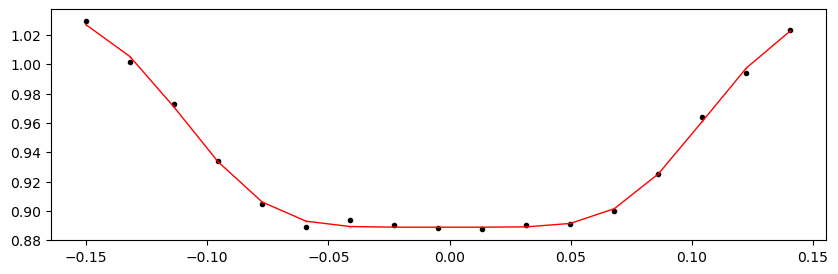

2716.6056338 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.86it/s]


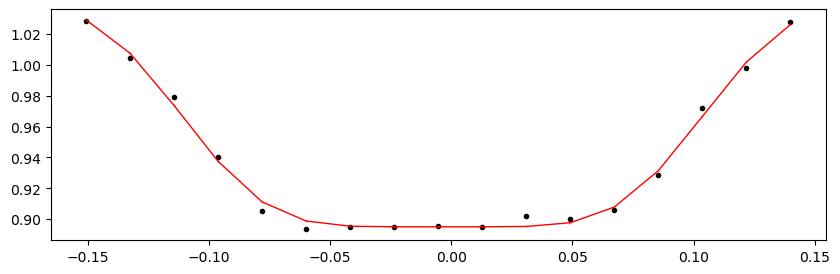

2716.98786442 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.03it/s]


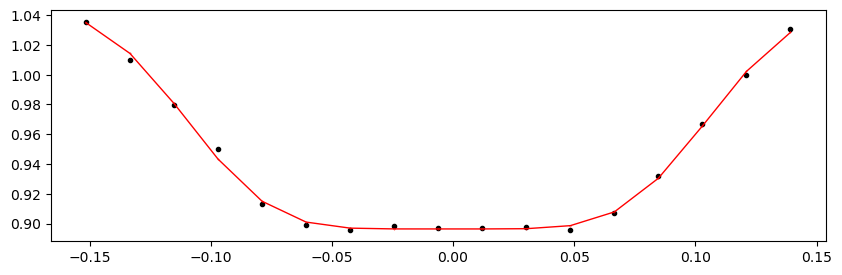

2717.37009504 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.66it/s]


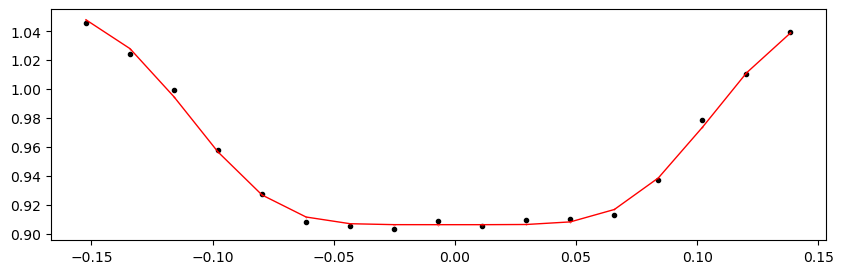

2718.89901752 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.90it/s]


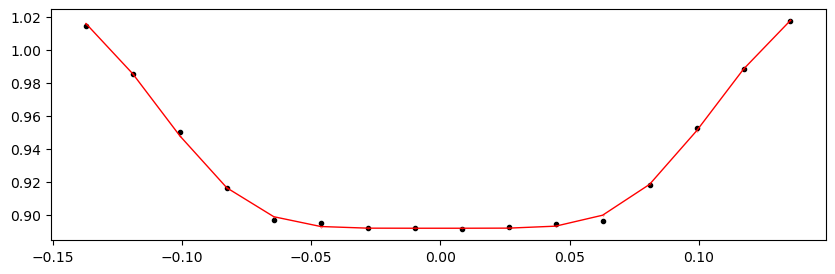

2719.28124814 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.68it/s]


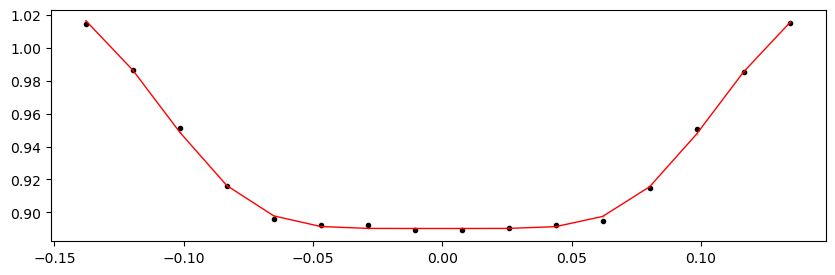

2719.66347876 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.02it/s]


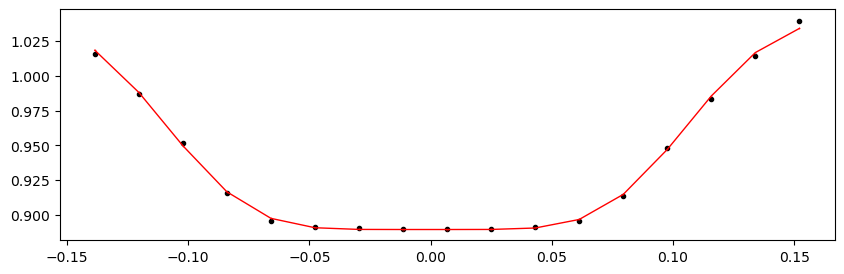

2720.04570938 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.81it/s]


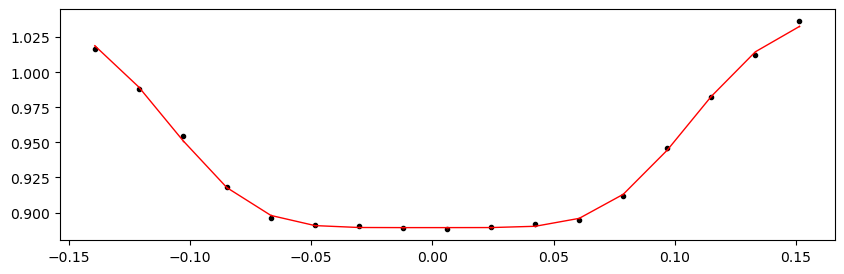

2720.42794 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.31it/s]


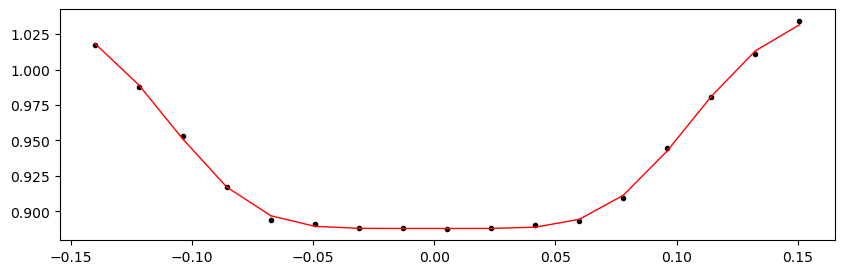

2725.39693806 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.87it/s]


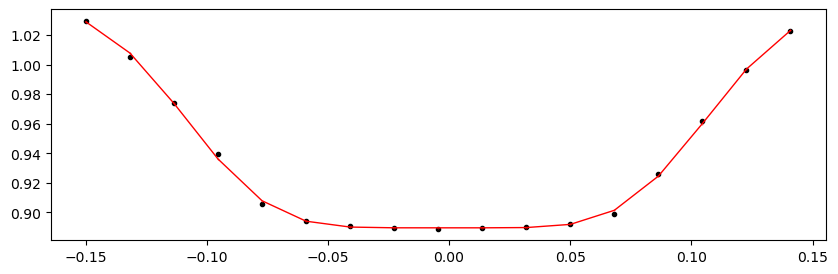

2725.77916868 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.03it/s]


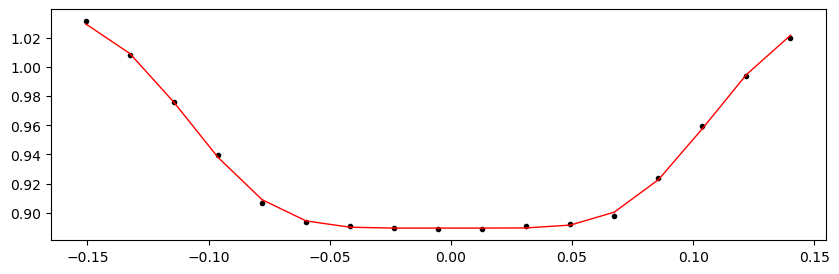

2726.1613993 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.73it/s]


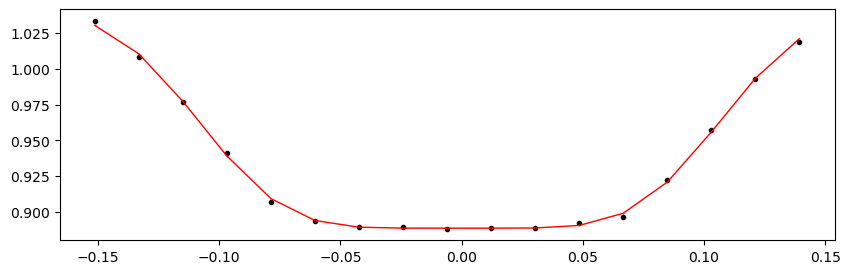

2726.54362992 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.54it/s]


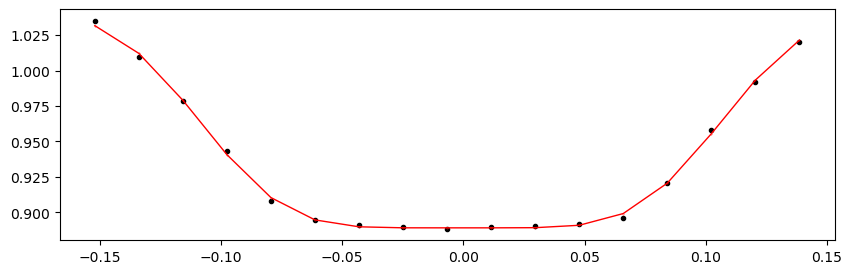

2726.92586054 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.93it/s]


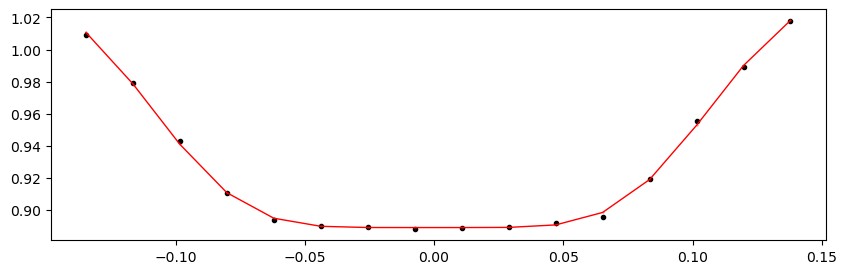

2727.30809116 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.13it/s]


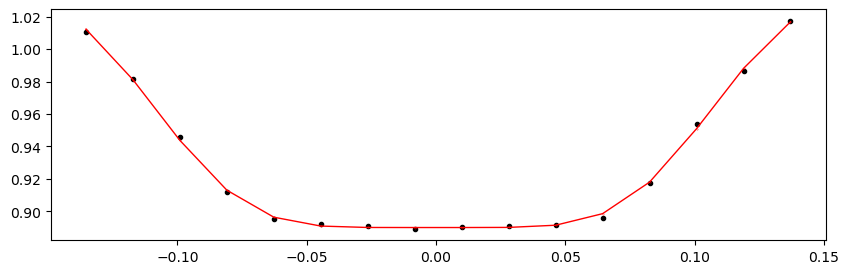

2727.69032178 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.19it/s]


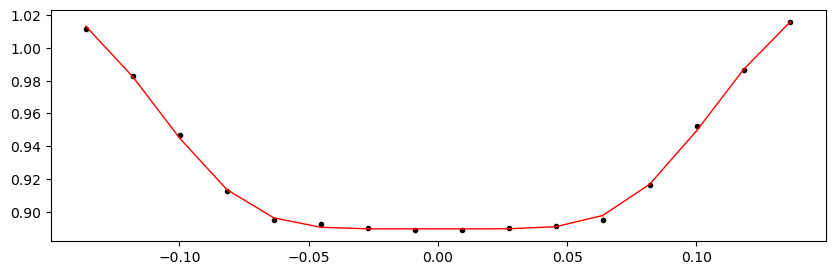

2728.0725524 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.83it/s]


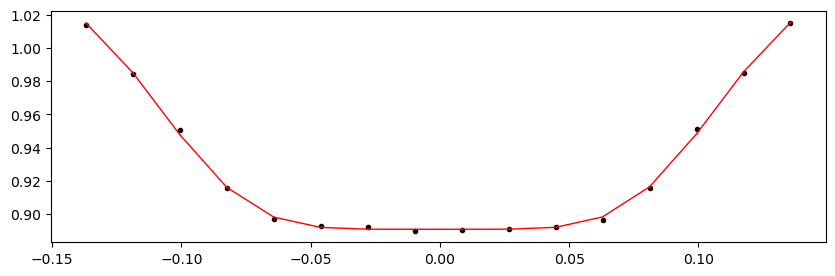

2728.45478302 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.26it/s]


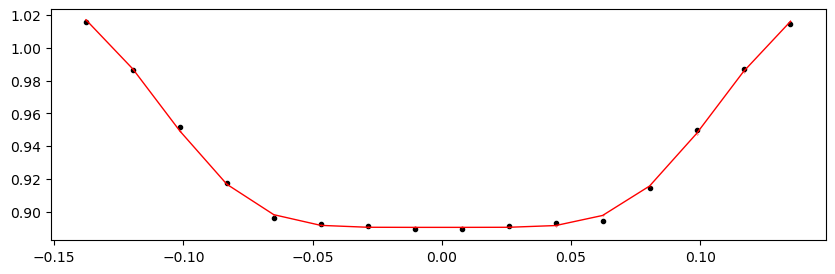

2728.83701364 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.11it/s]


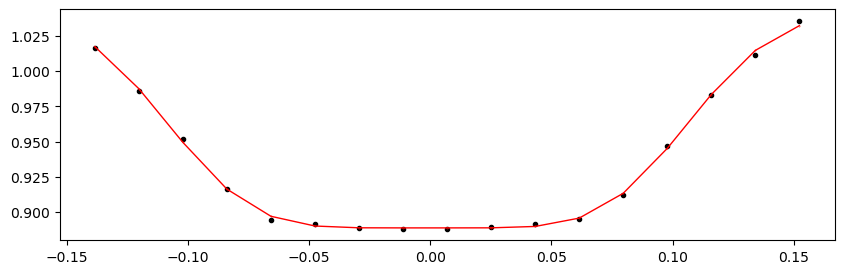

2729.21924426 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.15it/s]


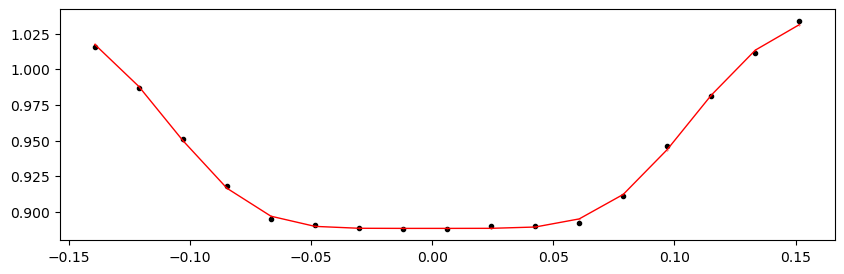

2729.60147488 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.97it/s]


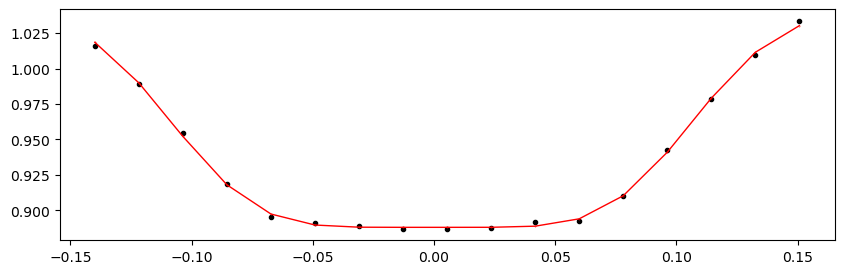

2729.9837055 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.26it/s]


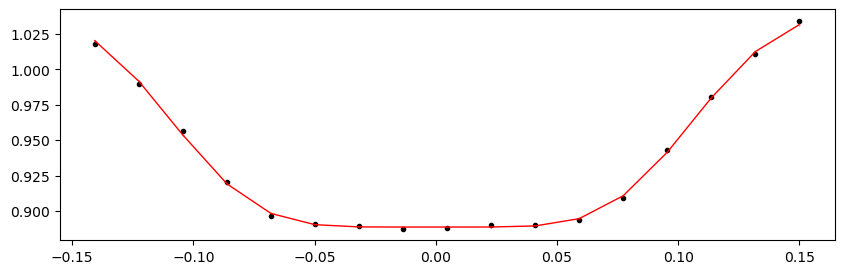

2731.5126279799997 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.98it/s]


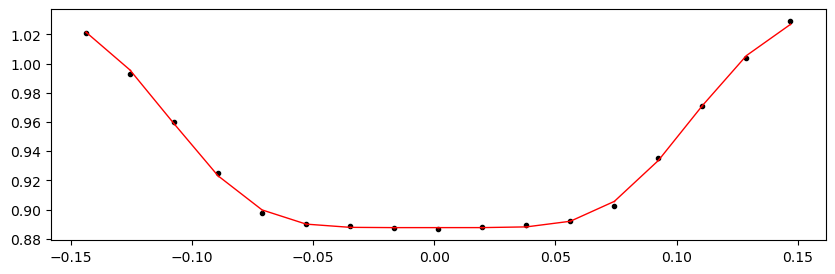

2731.8948586 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.94it/s]


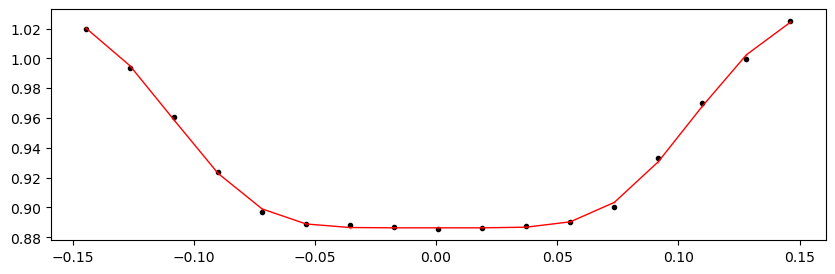

2732.27708922 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.71it/s]


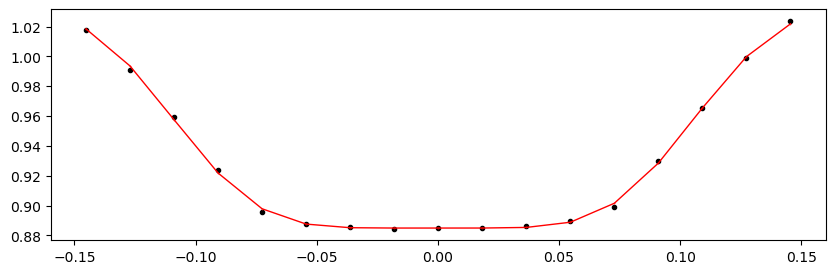

2732.65931984 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.51it/s]


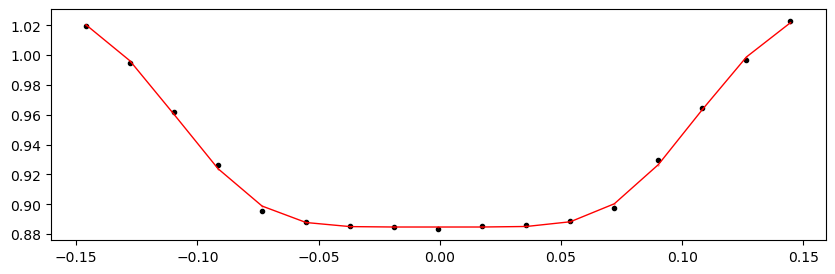

2733.04155046 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.47it/s]


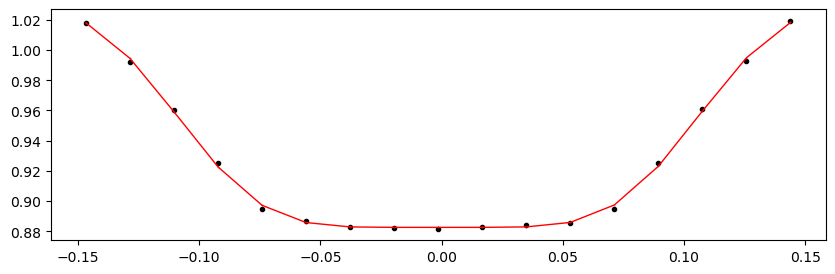

2733.42378108 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.40it/s]


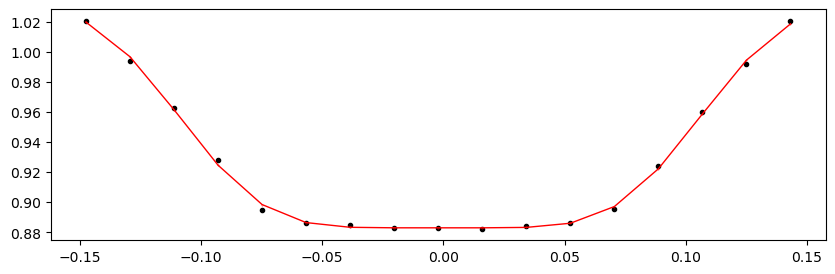

2738.39277914 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.53it/s]


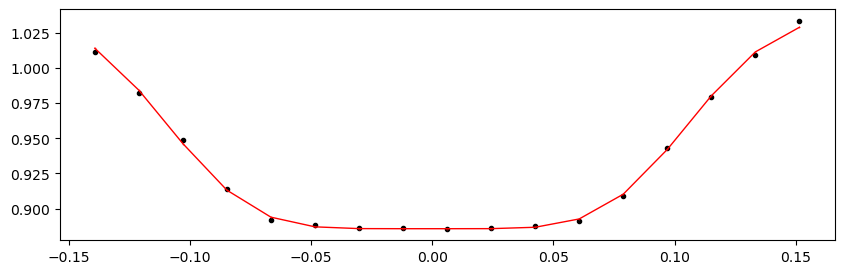

2738.77500976 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.55it/s]


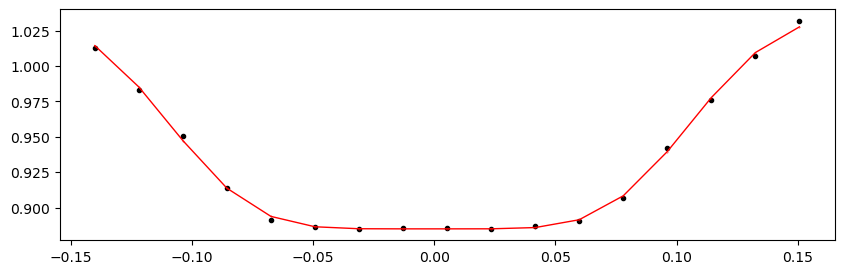

2739.15724038 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.33it/s]


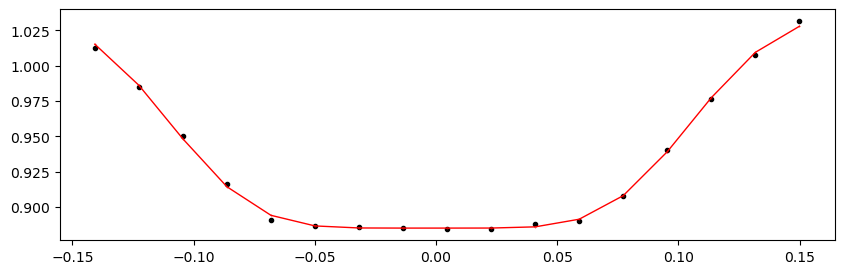

2739.539471 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.20it/s]


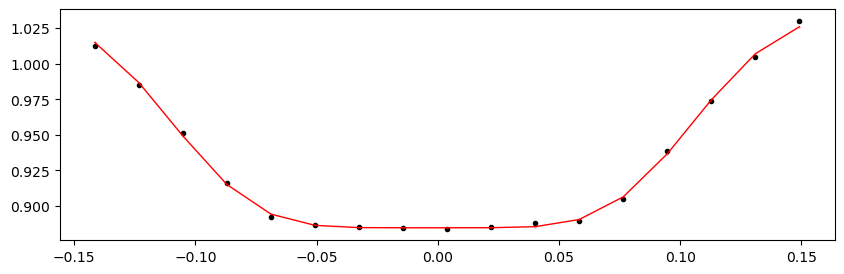

2739.92170162 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.30it/s]


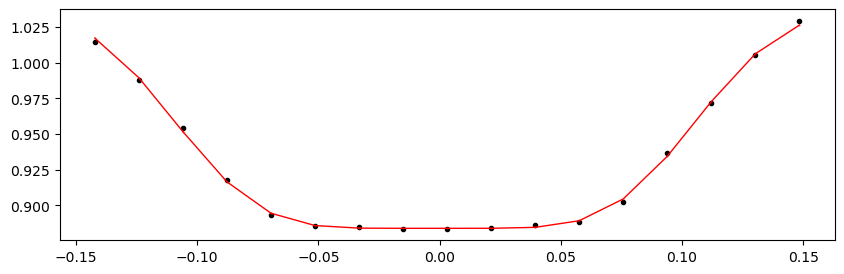

2740.30393224 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.87it/s]


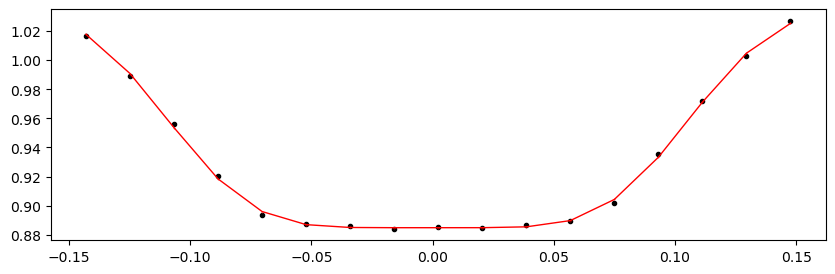

2740.68616286 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.84it/s]


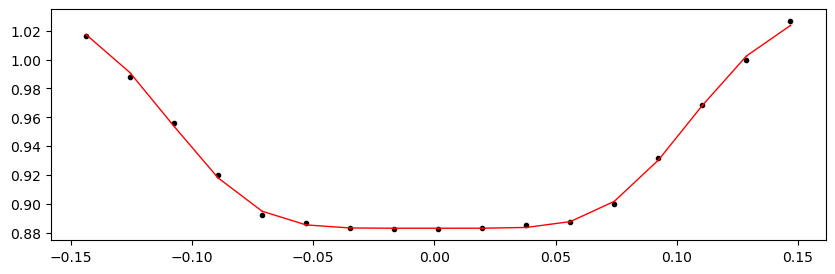

2741.06839348 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.70it/s]


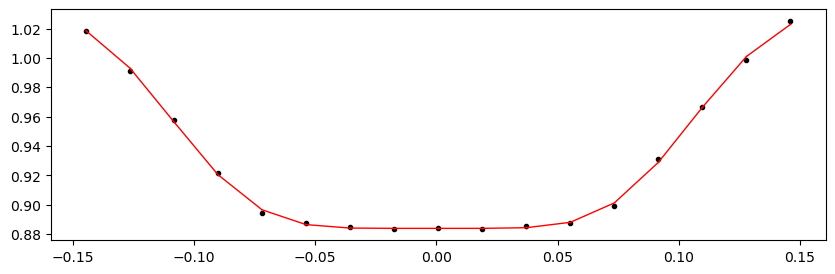

2741.4506241 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.05it/s]


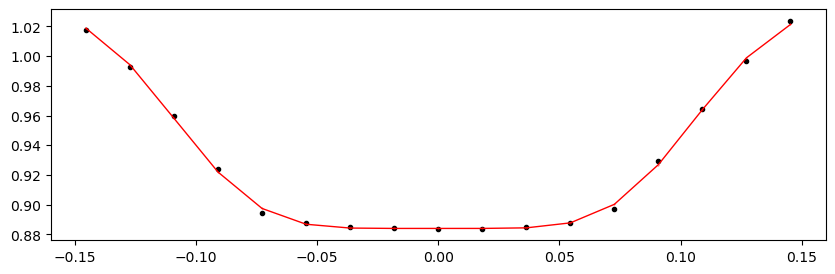

2741.83285472 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.27it/s]


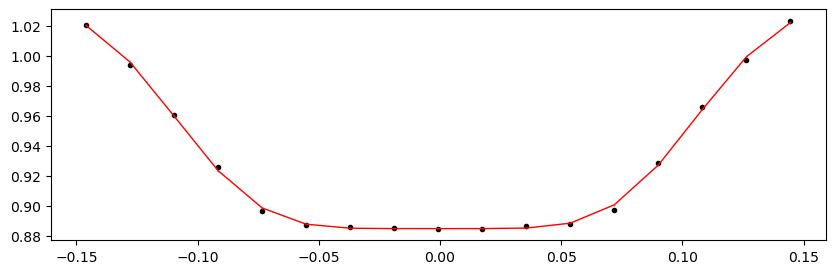

2742.21508534 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.17it/s]


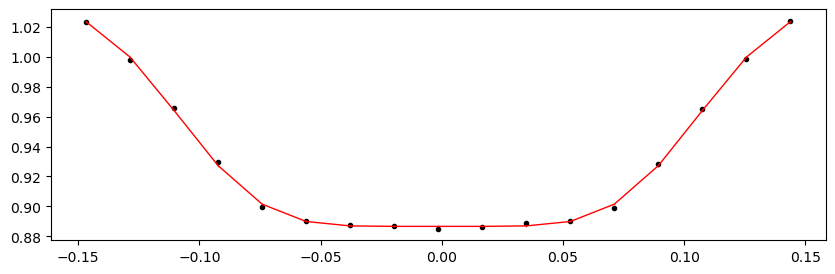

2742.59731596 1.037057578463065 -0.15117536481990043 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.97it/s]


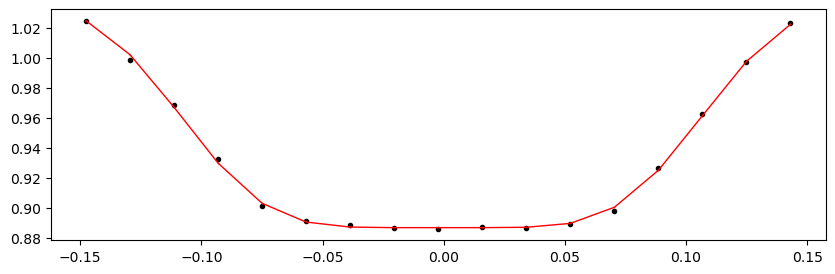

In [60]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=15,  # accomodate TESS-SPOC 10-min cadence data
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"


Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Number 3 has already been completed -- skip
Number 4 has already been completed -- skip
Number 5 has already been completed -- skip
Number 6 has already been completed -- skip
Number 7 has already been completed -- skip
Number 8 has already been completed -- skip
Number 9 has already been completed -- skip
Number 10 has already been completed -- skip
Number 11 has already been completed -- skip
Number 12 has already been completed -- skip
Number 13 has already been completed -- skip
Number 14 has already been completed -- skip
Number 15 has already been completed -- skip
Number 16 has already been completed -- skip
Number 17 has already been completed -- skip
Number 18 has already been completed -- skip
Number 19 has 

100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.44it/s]


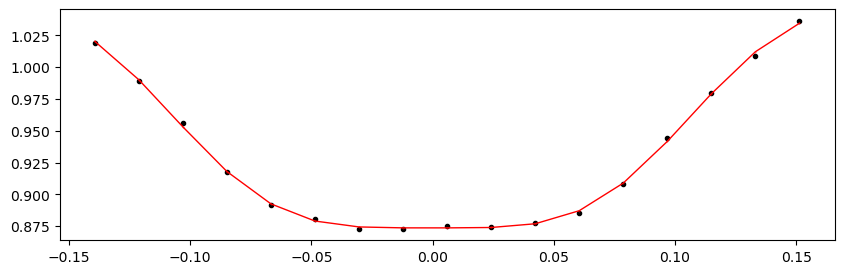

Time 2696.92075687 does not have enough data points: 7
2697.30298749 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.55it/s]


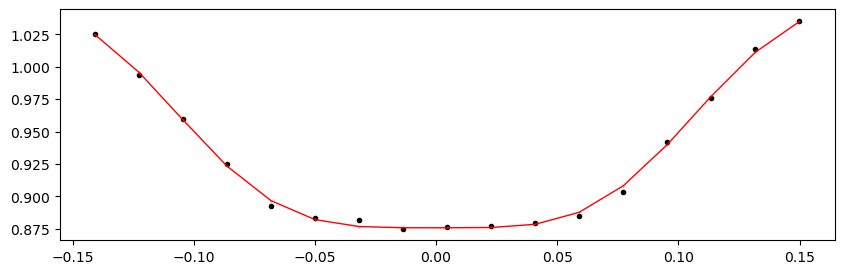

2697.68521811 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.78it/s]


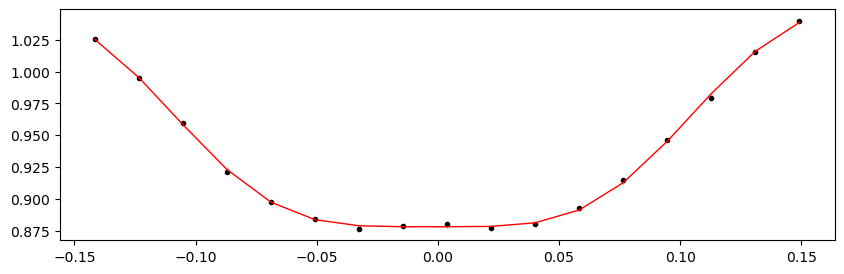

2698.0674487300003 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.56it/s]


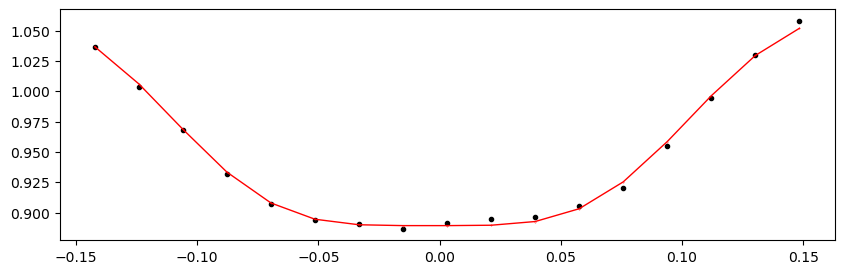

2698.44967935 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.49it/s]


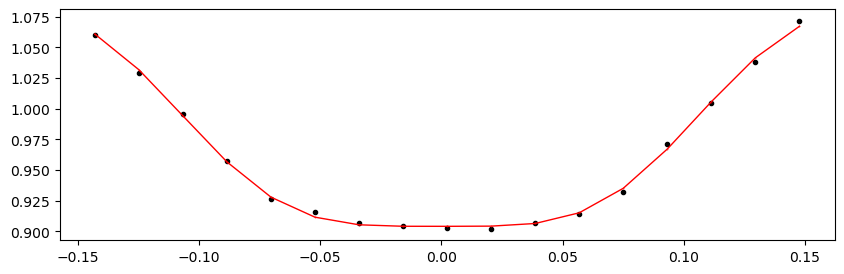

2698.83190997 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.13it/s]


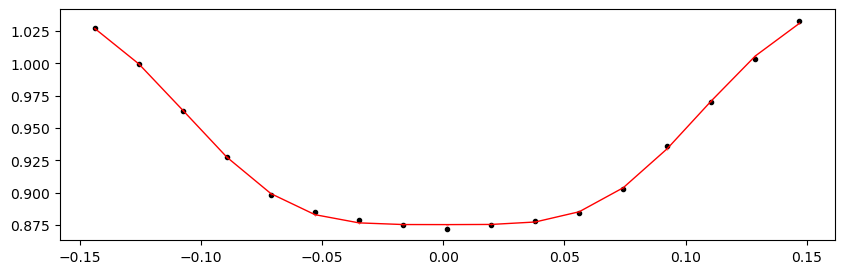

2699.21414059 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.68it/s]


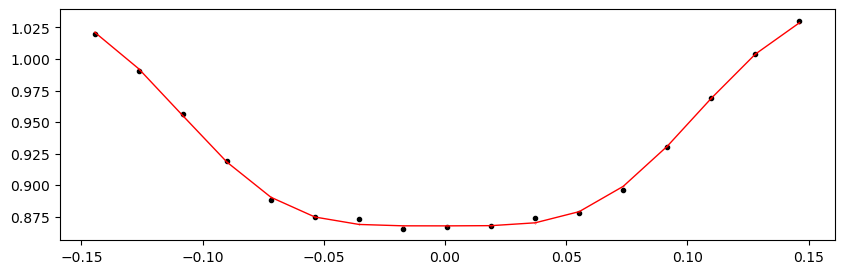

2699.59637121 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.30it/s]


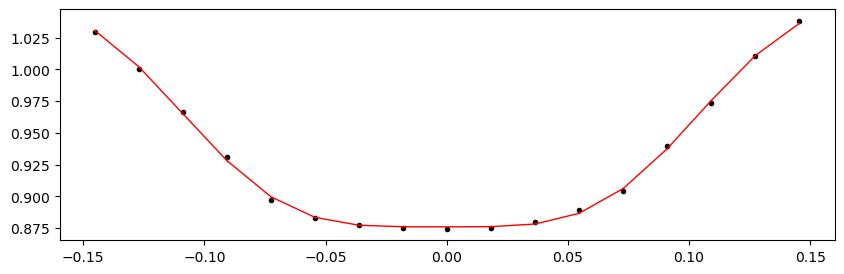

2699.97860183 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.53it/s]


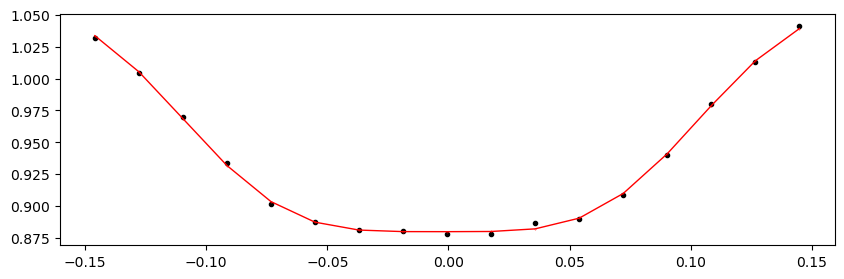

2700.36083245 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.18it/s]


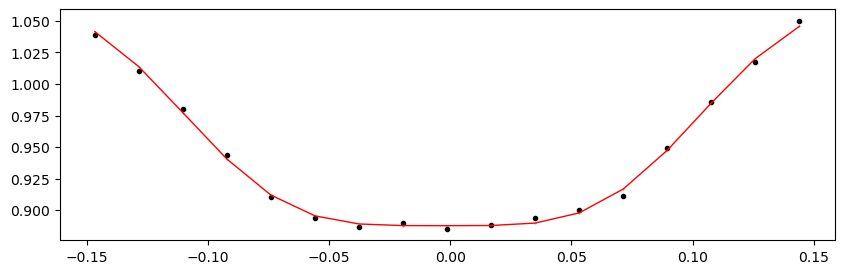

2700.74306307 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.11it/s]


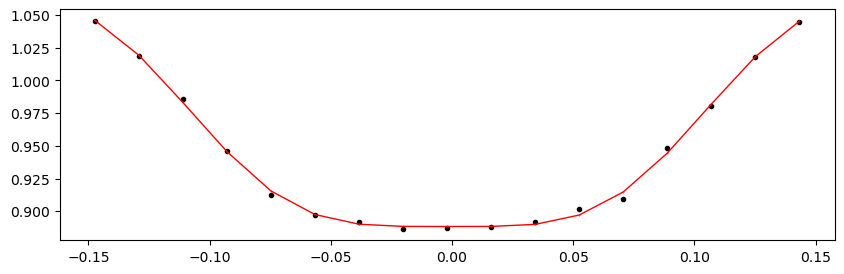

2701.12529369 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.43it/s]


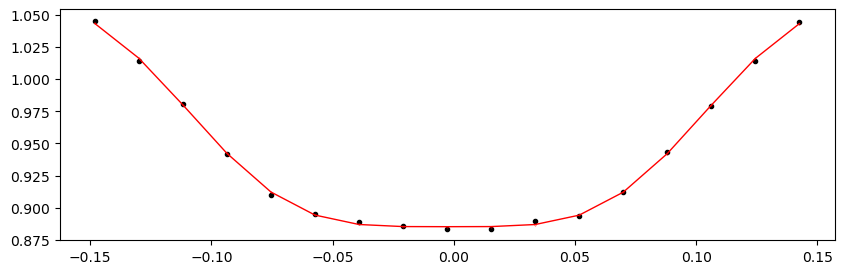

2701.50752431 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.56it/s]


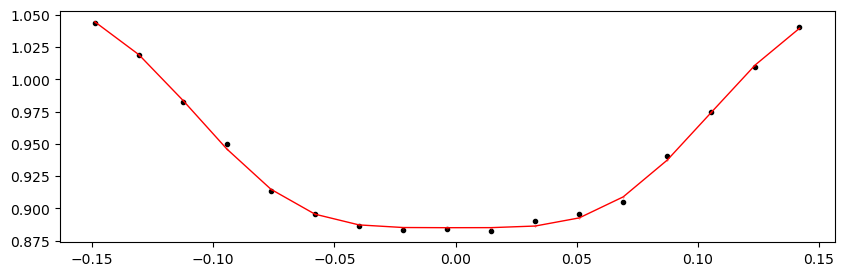

2701.88975493 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.73it/s]


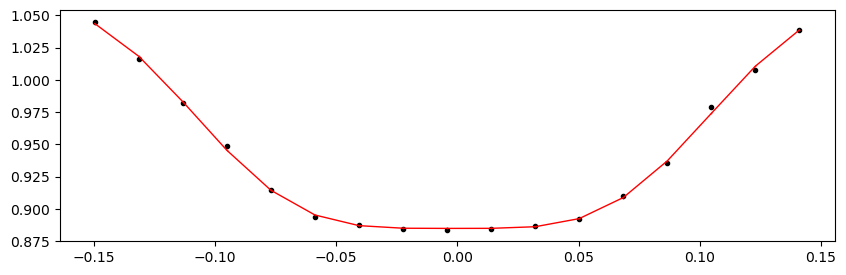

2702.27198555 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.67it/s]


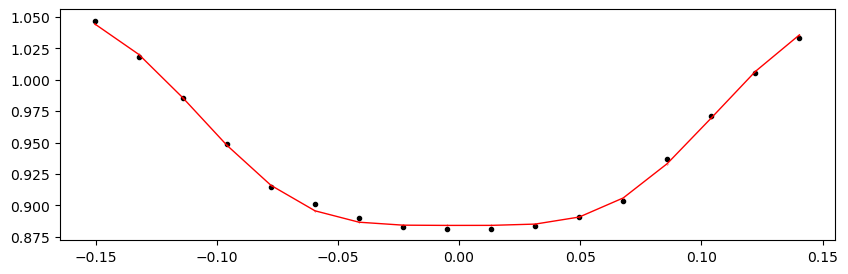

2702.65421617 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.77it/s]


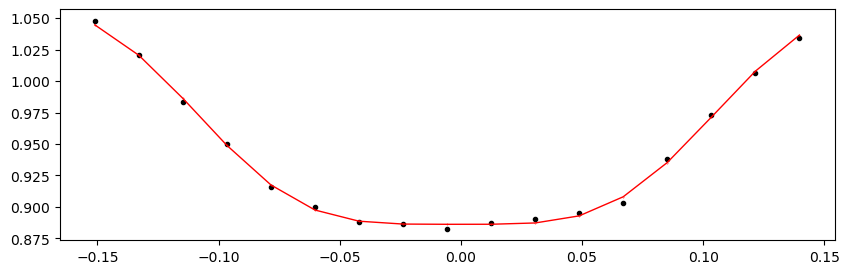

2703.03644679 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.70it/s]


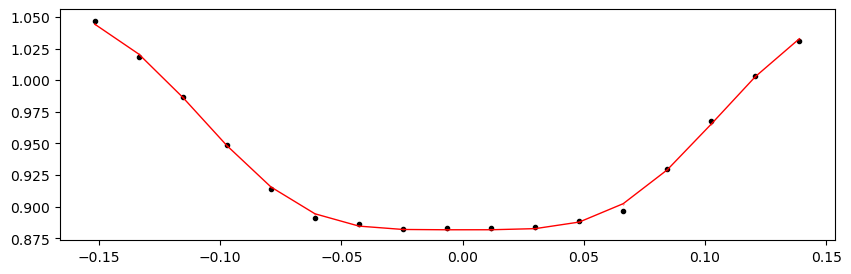

2703.41867741 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.72it/s]


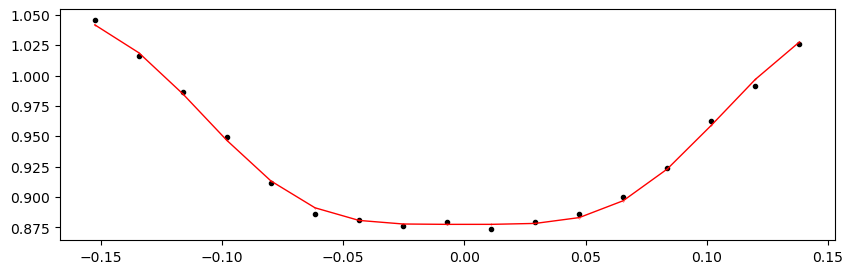

2703.80090803 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.83it/s]


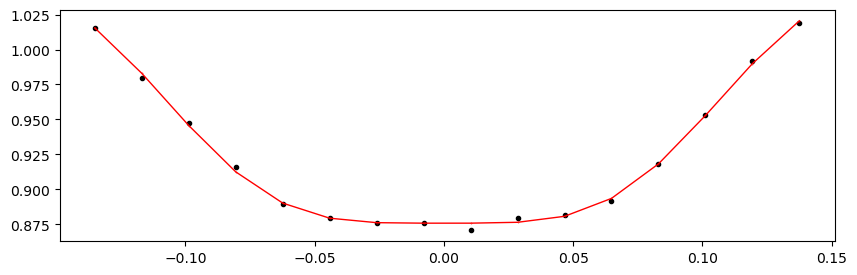

2704.18313865 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.92it/s]


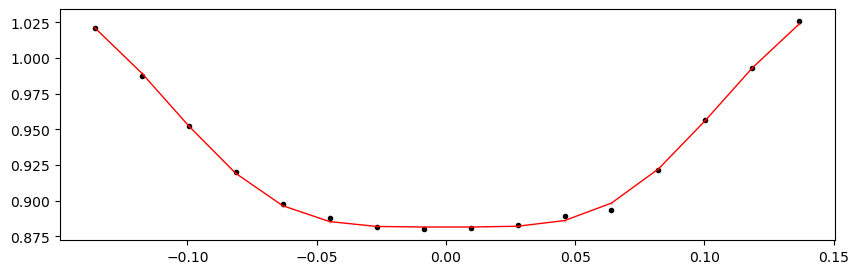

2704.56536927 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.36it/s]


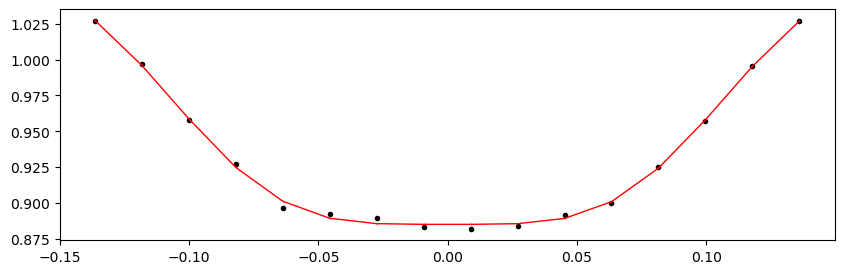

Time 2709.91659795 does not have enough data points: 8
2710.29882857 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.95it/s]


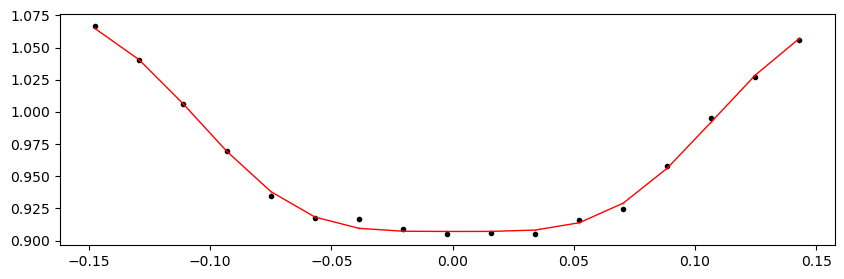

2710.68105919 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.27it/s]


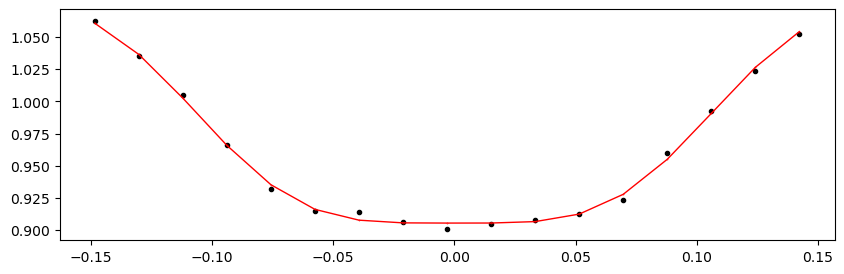

2711.0632898100002 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.05it/s]


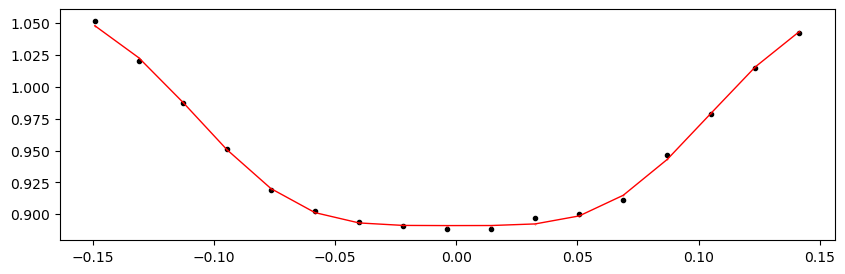

2711.44552043 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.55it/s]


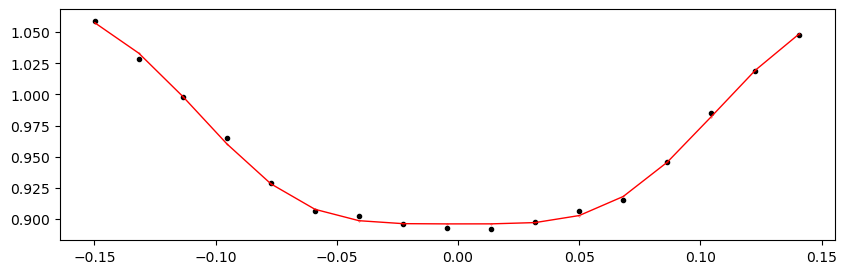

2711.82775105 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.08it/s]


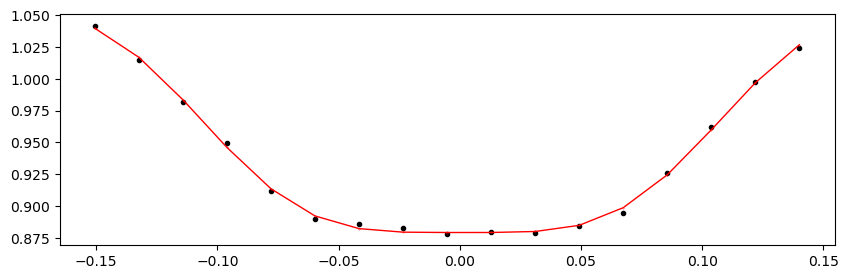

2712.20998167 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.20it/s]


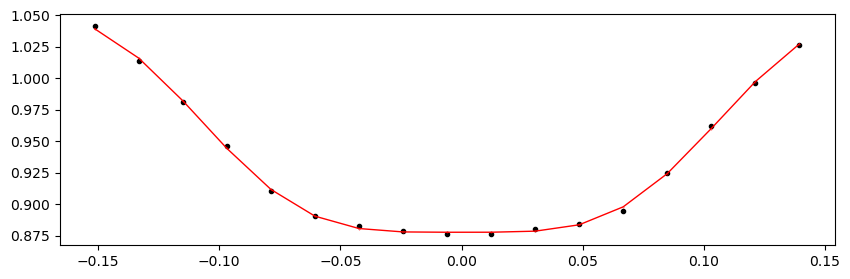

2712.59221229 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.66it/s]


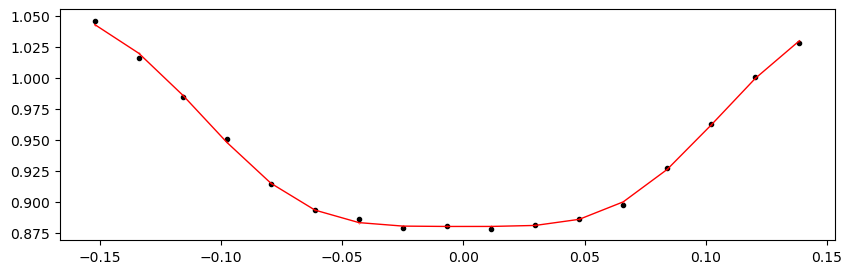

2712.97444291 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.75it/s]


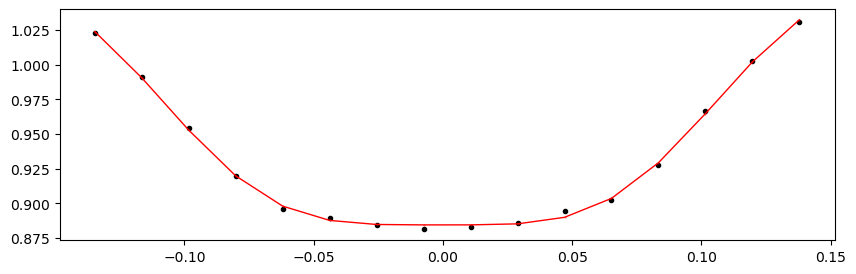

2713.35667353 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.22it/s]


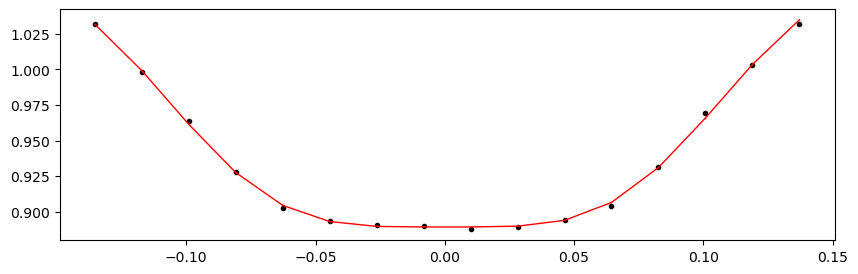

2713.73890415 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.27it/s]


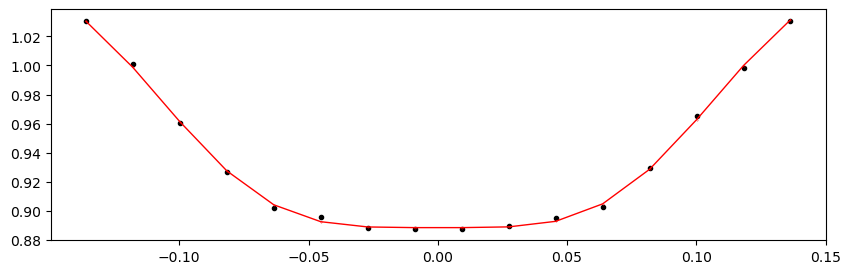

2714.12113477 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.67it/s]


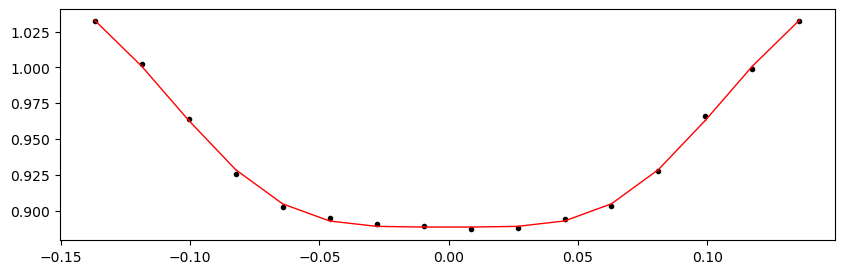

2714.50336539 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.68it/s]


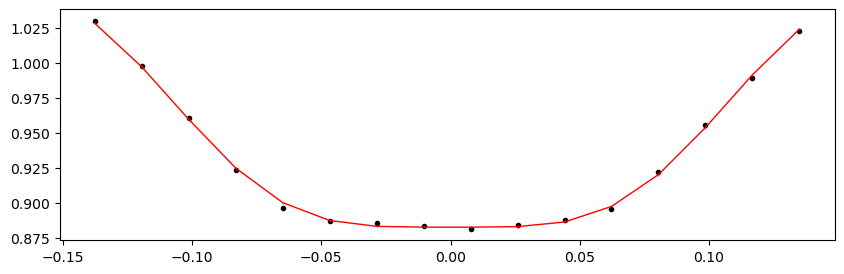

2714.88559601 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.03it/s]


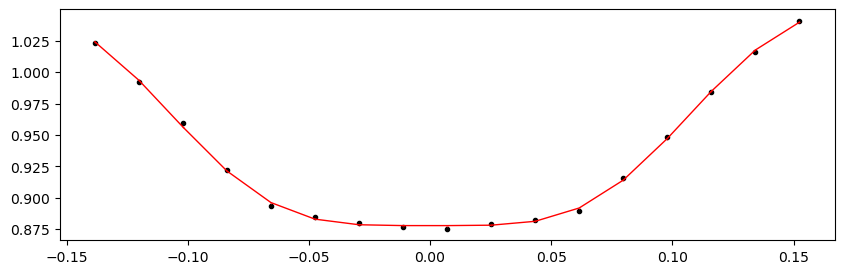

2715.26782663 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.56it/s]


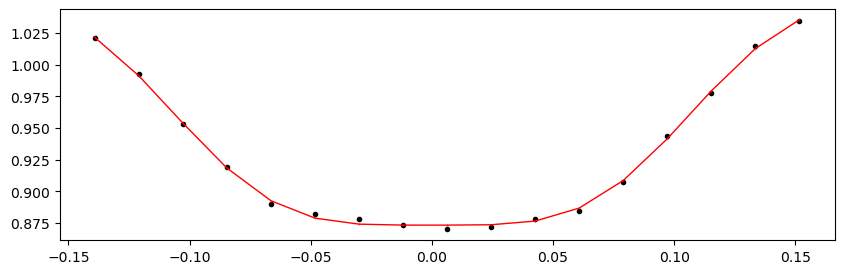

2715.65005725 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.15it/s]


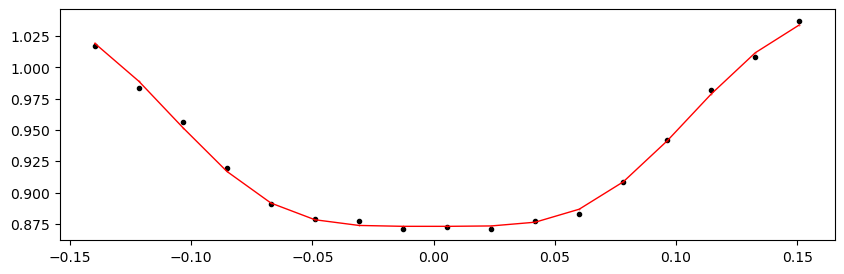

2716.03228787 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.57it/s]


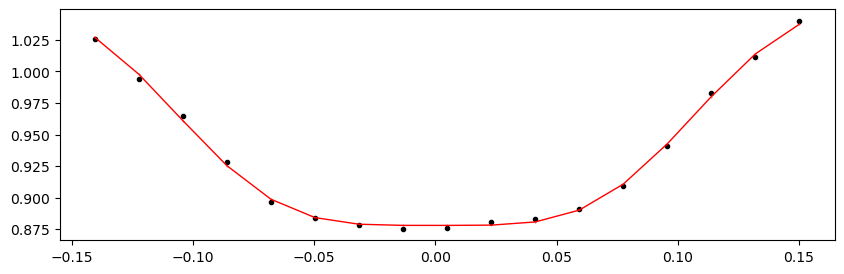

2716.41451849 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.75it/s]


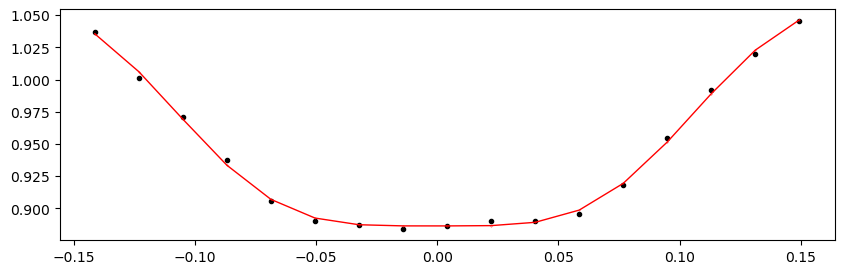

2716.79674911 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.60it/s]


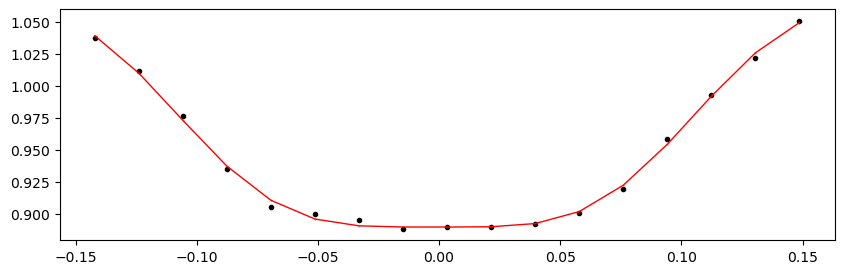

2717.17897973 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.49it/s]


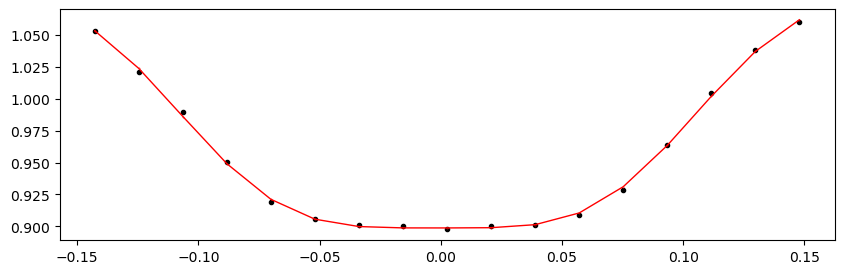

Time 2717.56121035 does not have enough data points: 5
2718.7079022099997 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.97it/s]


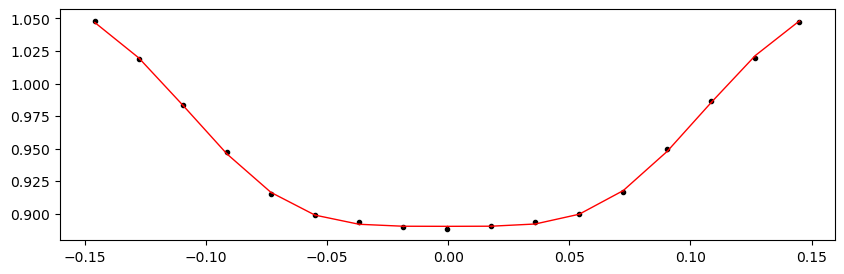

2719.09013283 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.77it/s]


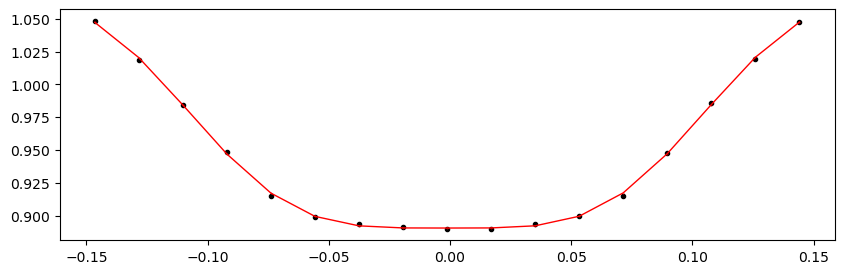

2719.47236345 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.05it/s]


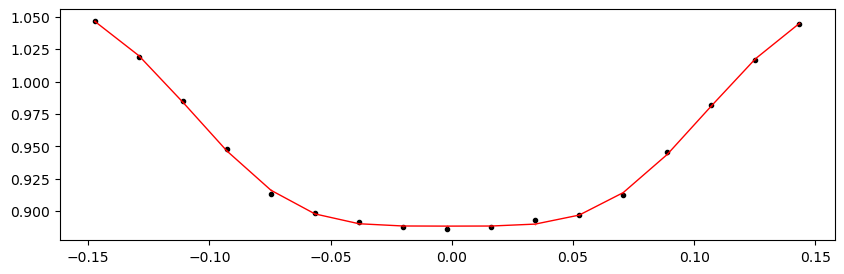

2719.85459407 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.53it/s]


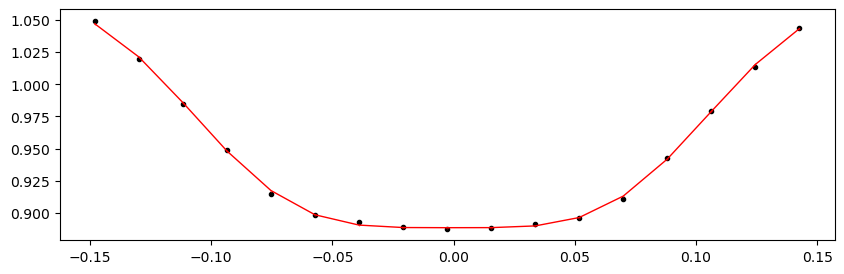

Time 2720.23682469 does not have enough data points: 15
Time 2720.61905531 does not have enough data points: 7
2725.58805337 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.87it/s]


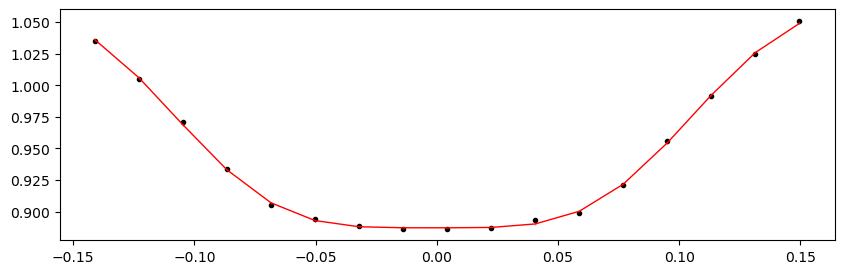

2725.97028399 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.84it/s]


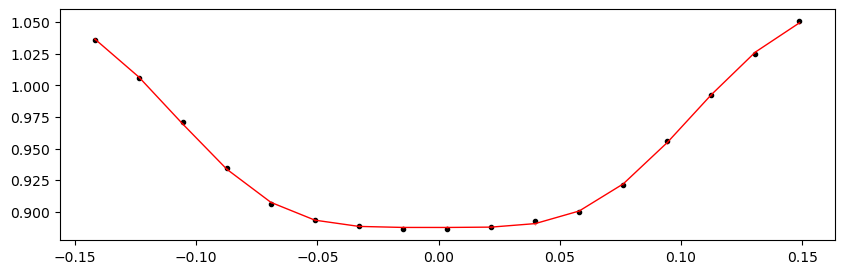

2726.35251461 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.96it/s]


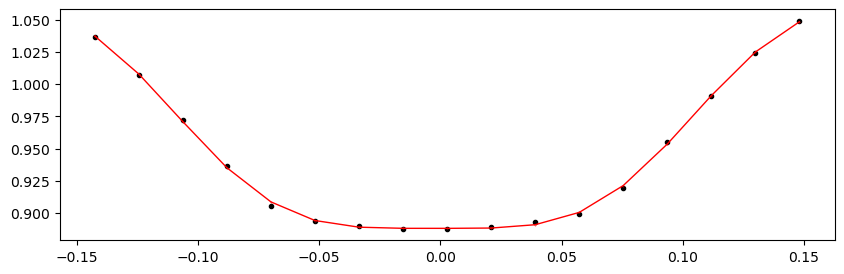

2726.73474523 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.68it/s]


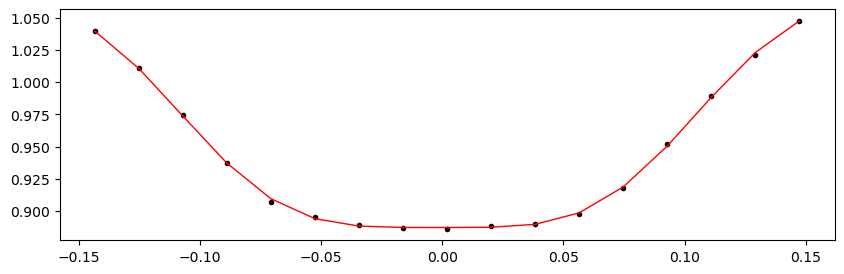

2727.11697585 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.72it/s]


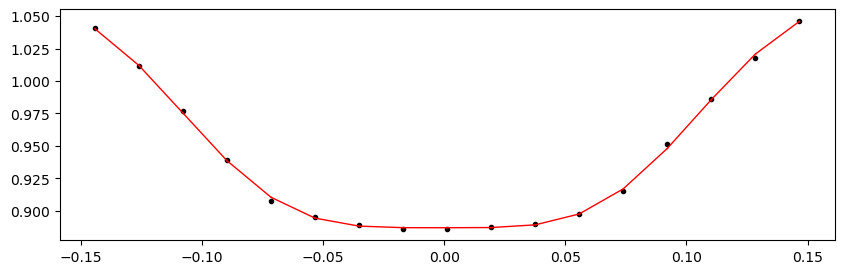

2727.49920647 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.29it/s]


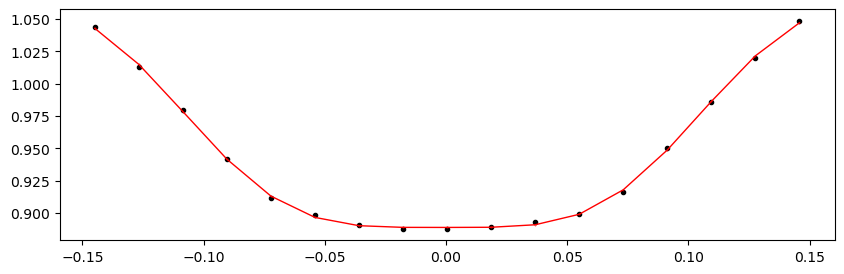

2727.88143709 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.40it/s]


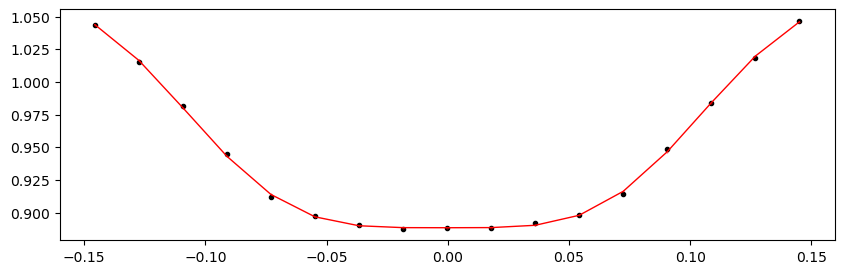

2728.26366771 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.29it/s]


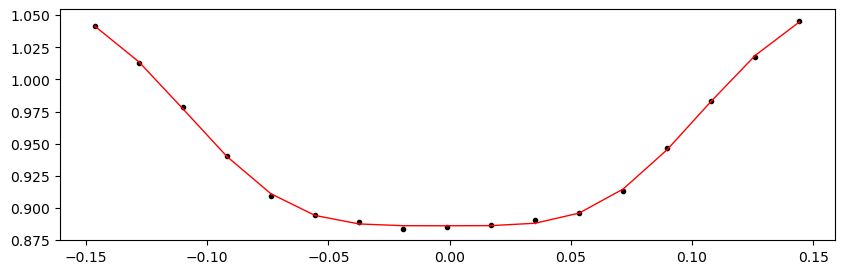

2728.64589833 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.54it/s]


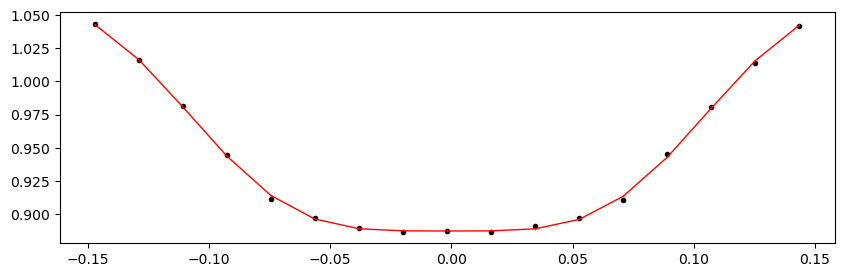

2729.02812895 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.57it/s]


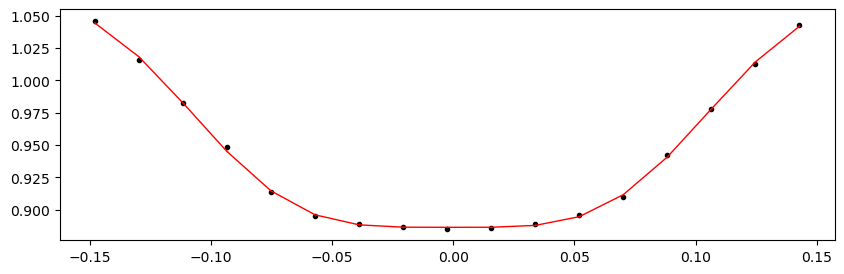

2729.41035957 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.13it/s]


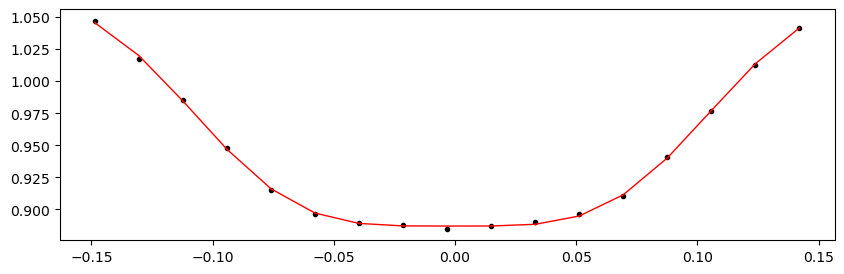

2729.79259019 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.69it/s]


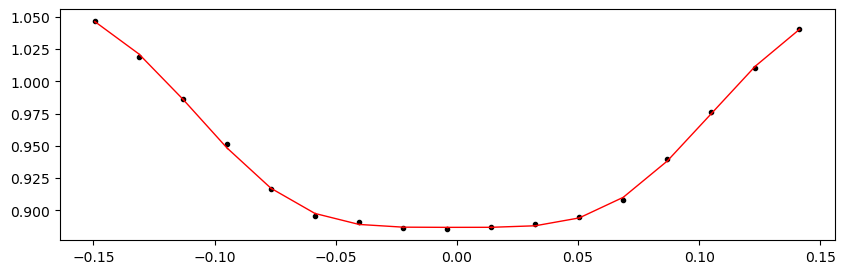

2730.17482081 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.34it/s]


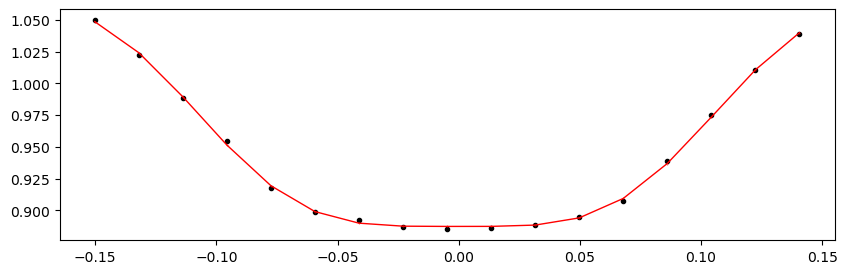

2731.7037432899997 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.39it/s]


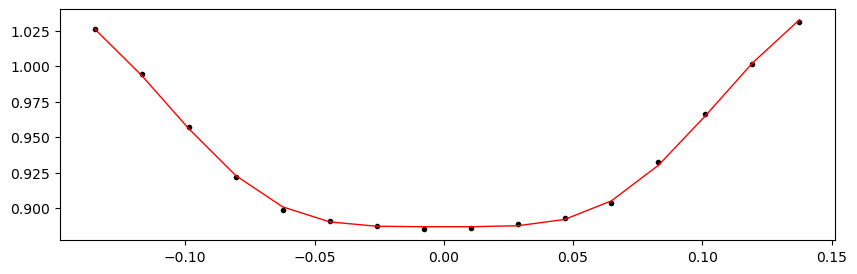

2732.08597391 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.83it/s]


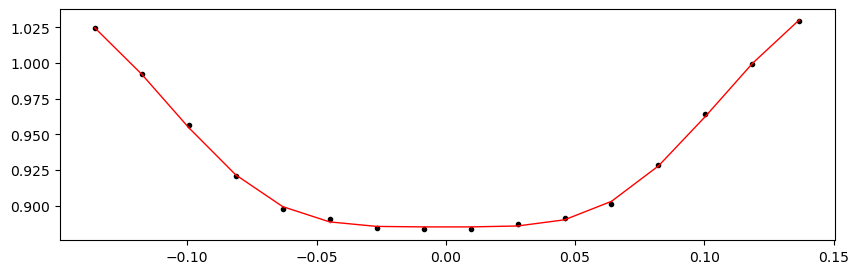

2732.46820453 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.83it/s]


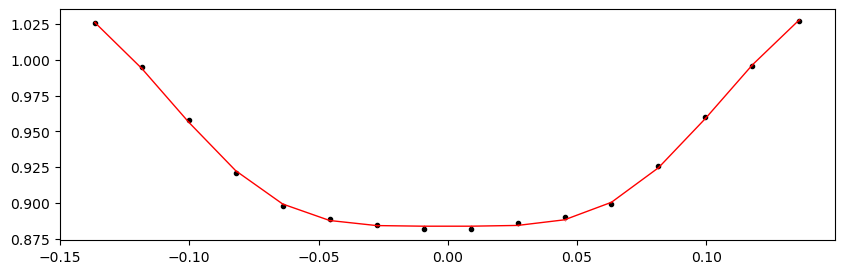

2732.85043515 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.20it/s]


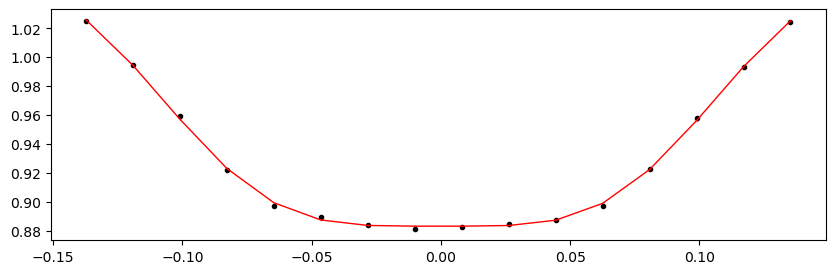

2733.23266577 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.28it/s]


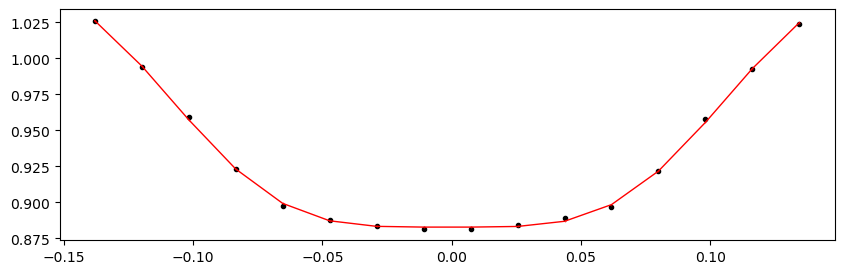

Time 2733.61489639 does not have enough data points: 9
Time 2738.20166383 does not have enough data points: 3
2738.58389445 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.62it/s]


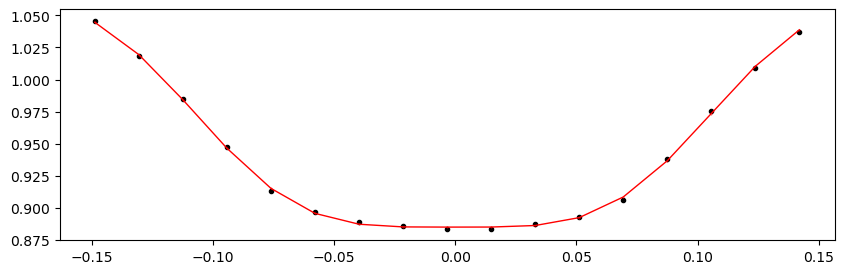

2738.96612507 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.69it/s]


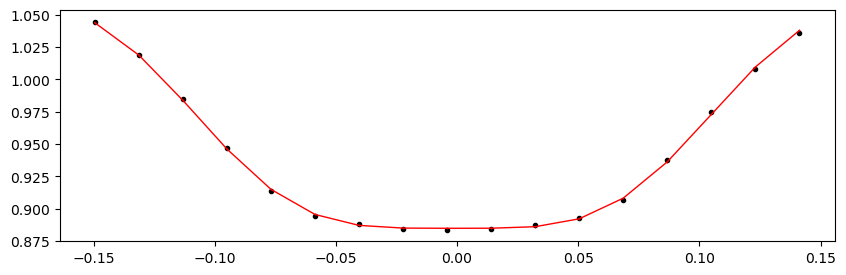

2739.34835569 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.53it/s]


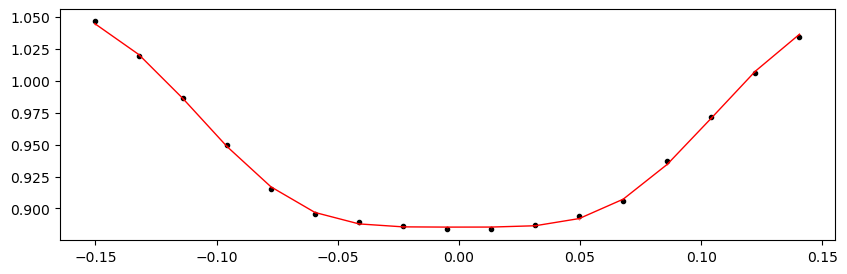

2739.73058631 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.26it/s]


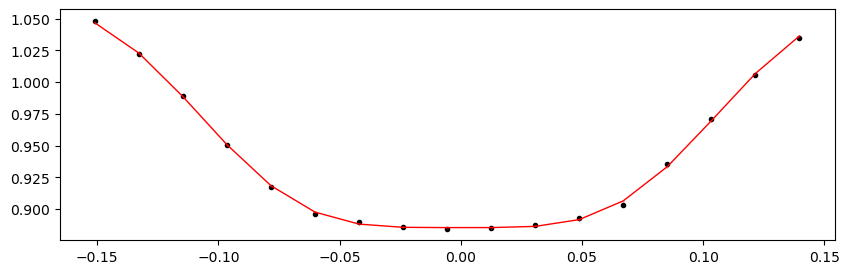

2740.11281693 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.26it/s]


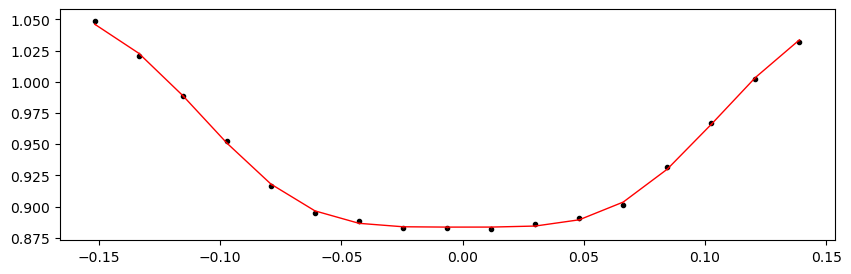

2740.49504755 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.80it/s]


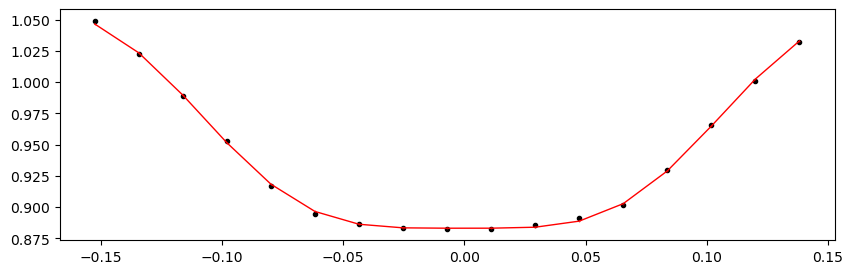

2740.87727817 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.23it/s]


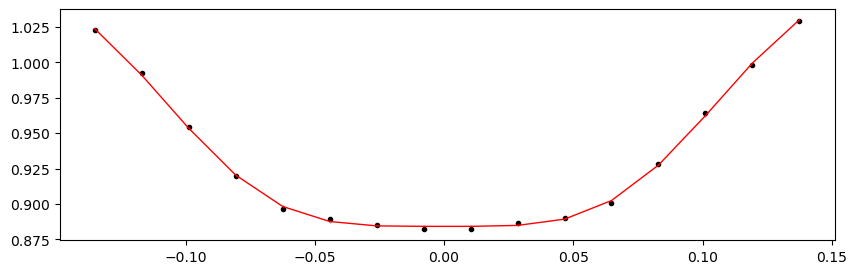

2741.25950879 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.82it/s]


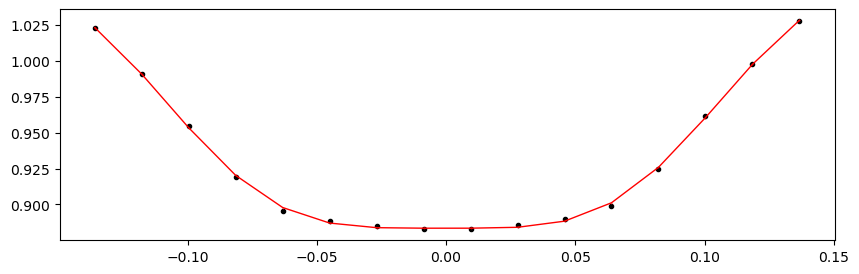

2741.64173941 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.92it/s]


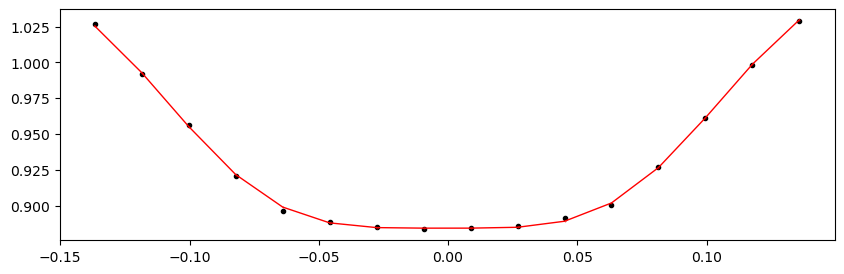

2742.02397003 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.55it/s]


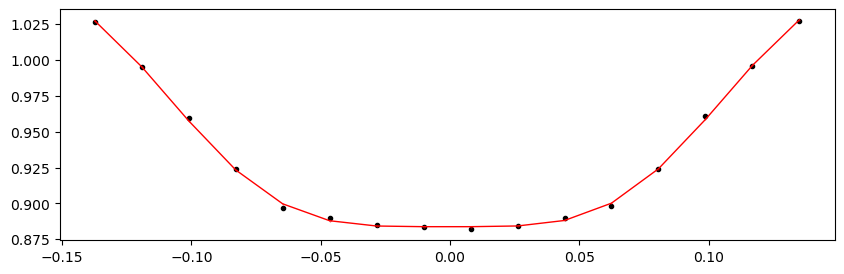

2742.40620065 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.96it/s]


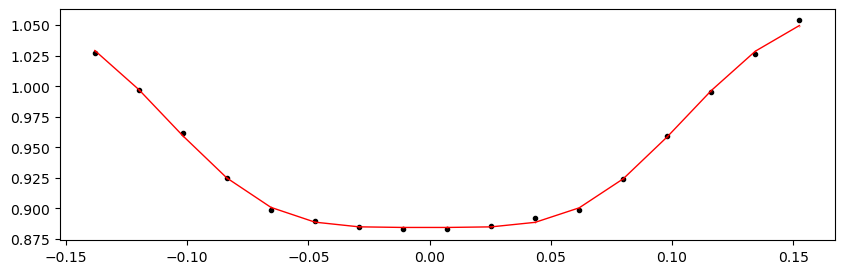

2742.78843127 1.0639617979416593 -0.17993873081408018 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.95it/s]


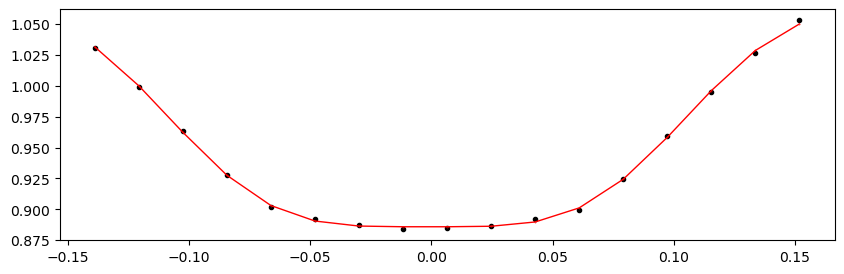

In [61]:
# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=15,  # accomodate TESS-SPOC 10-min cadence data
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

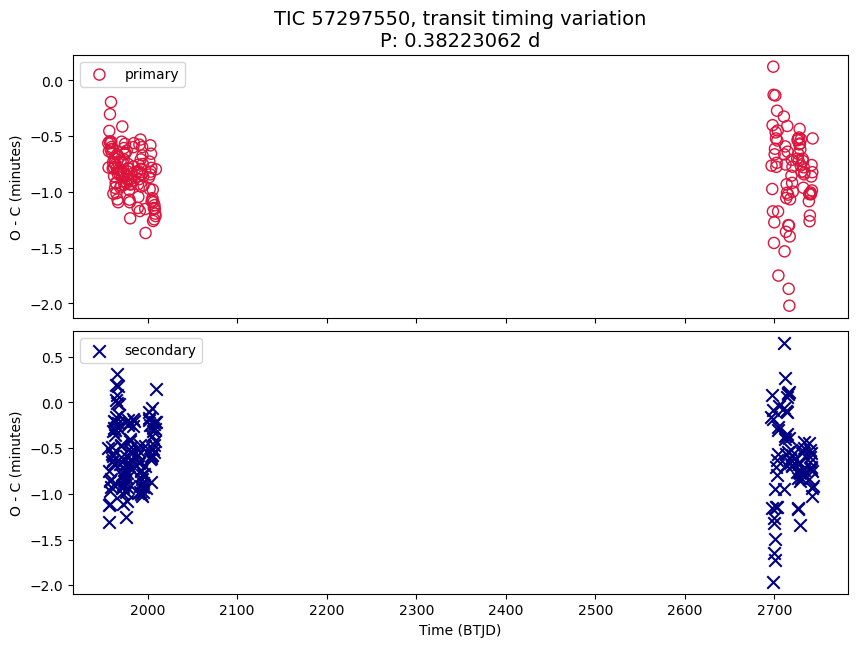

In [62]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              lw = 1, color = 'crimson', )
axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
# axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
#              lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    # axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
    #              lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, transit timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

### Compare with O-C plot with wider widow for clipped LC

Using a window of 3.5 hours for both primary and secondary eclipses.

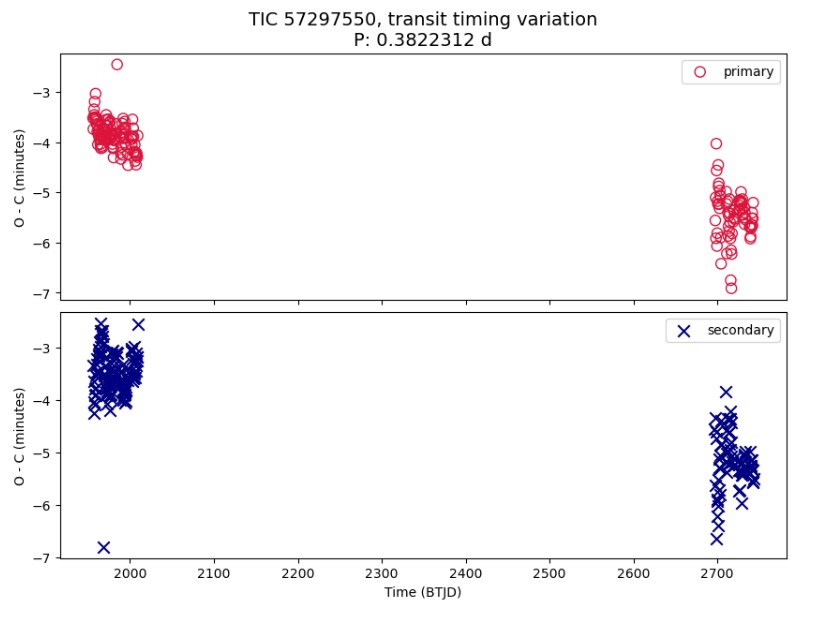

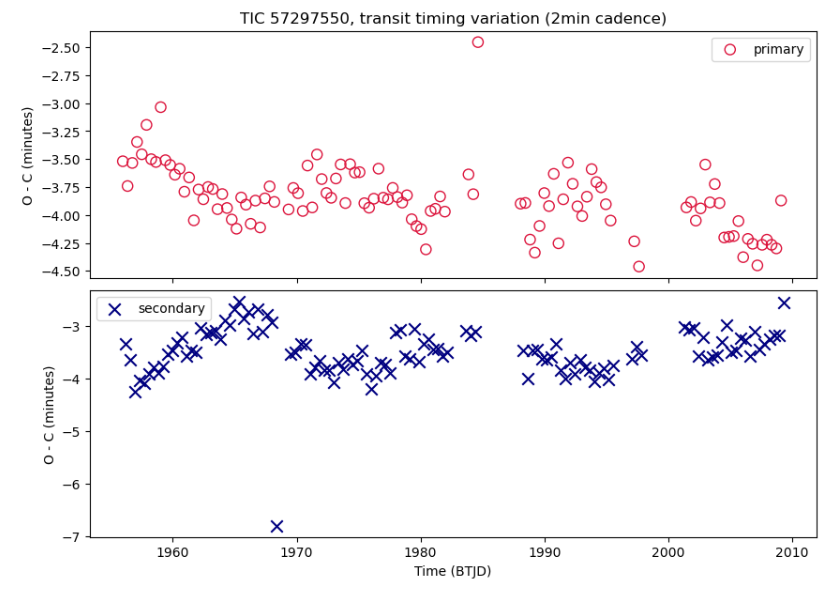

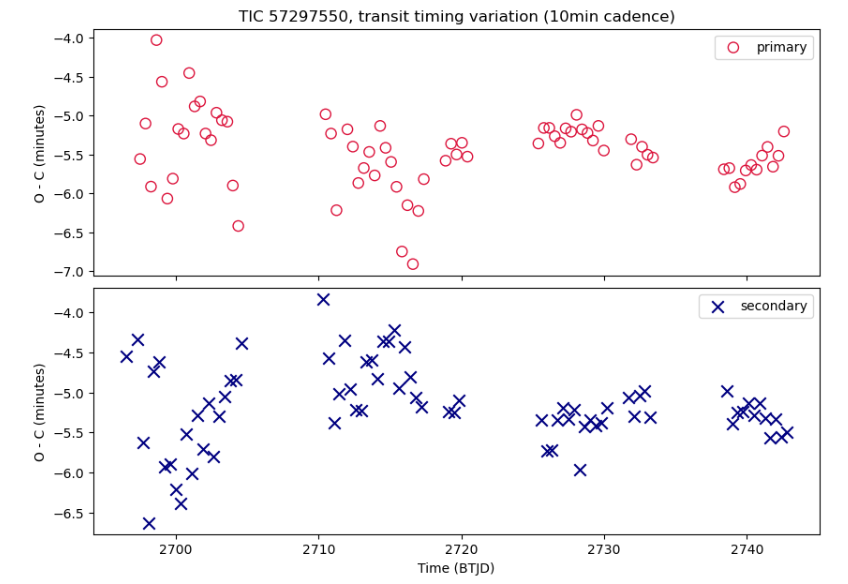

### O-C Plot, Zoom In

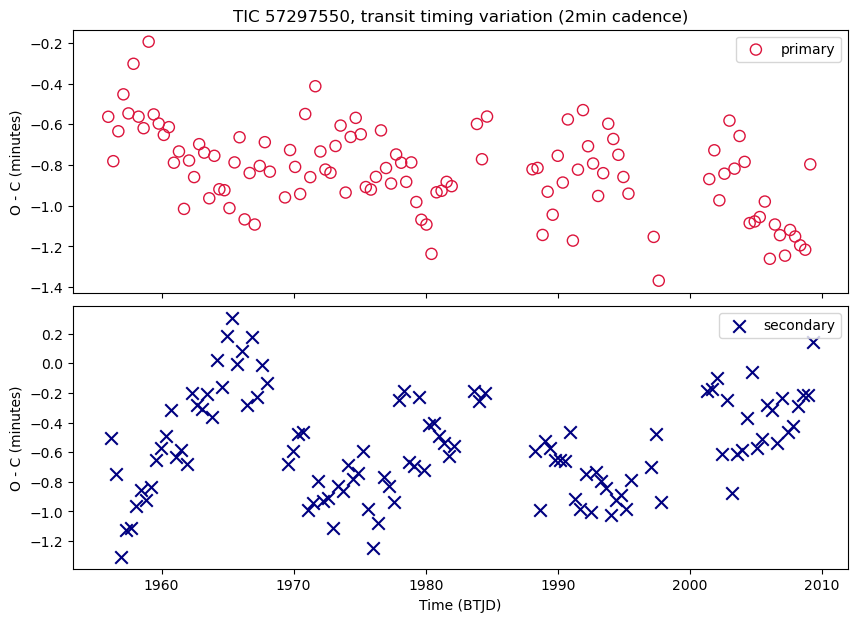

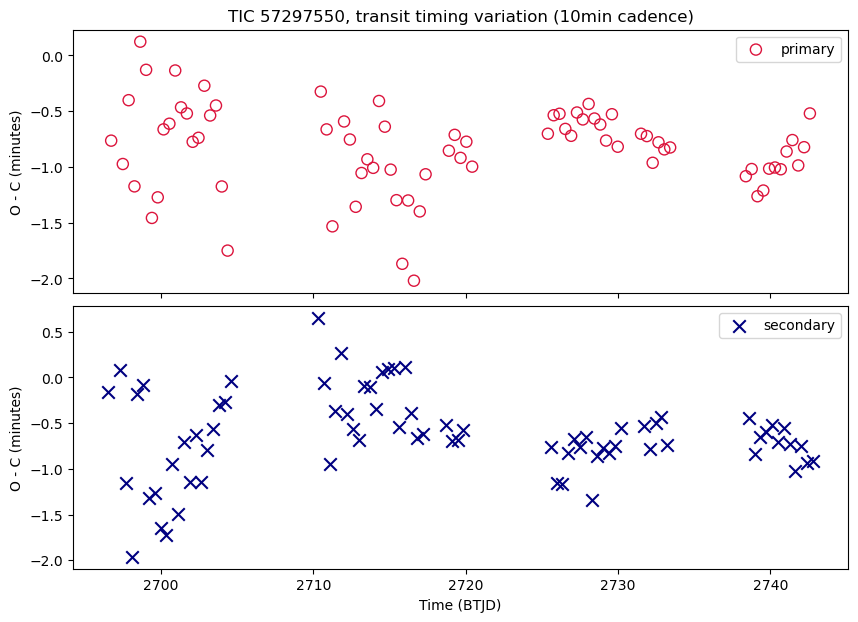

In [64]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1950, 2020),
    (2650, 2750),
]
title_suffix = "transit timing variation"

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    ax = axs_list[0][0]
    ax.set_title(f"{ax.get_title()} (2min cadence)")
    ax = axs_list[1][0]
    ax.set_title(f"{ax.get_title()} (10min cadence)")
    
    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
    
        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]
        
        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]
              
        axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'], 
                       marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        # axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'], 
        #                 lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")
        
        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]
        
            axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
                           marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            # axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
            #                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
        
        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();
        
        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)
        
        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

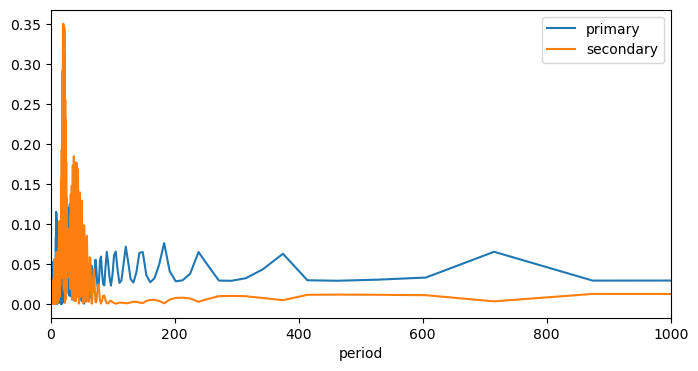

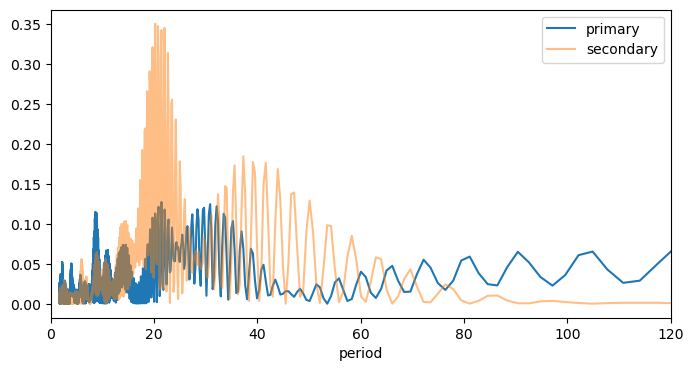

In [72]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 1000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary', alpha=0.5)    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 120)
    plt.show()

## O-C plot, folded

- for periodic trend in O-C

In [67]:
def truncate_freq_power_to_period_range(freq, power, period_min, period_max):
    f, p = freq, power
    if period_min is not None:
        f, p = f[f < 1 / period_min], p[f < 1 / period_min]
    if period_max is not None:
        f, p = f[f > 1 / period_max], p[f >  1 / period_max]
    return f, p


def plot_oc_folded(period_min=None, period_max=None, period_min_s=None, period_max_s=None, period=None, period_s=None):

    if period is None:
        _f, _p = truncate_freq_power_to_period_range(frequency, power, period_min, period_max)
        period = 1 / _f[np.argmax(_p)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=12**2, c=in_df_primary.epoch);
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'None', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period:.4f} d", fontsize=14)

    if in_df_secondary is not None:
        if period_s is None:
            _f, _p = truncate_freq_power_to_period_range(frequency_s, power_s, period_min_s, period_max_s)
            period_s= 1 / _f[np.argmax(_p)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_s)
        axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'o',  s=12**2, c=in_df_secondary.epoch);
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color='None', ecolor='navy', markeredgecolor = 'None', label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_s:.4f} d", fontsize=14)

    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (Normalized)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    return axs

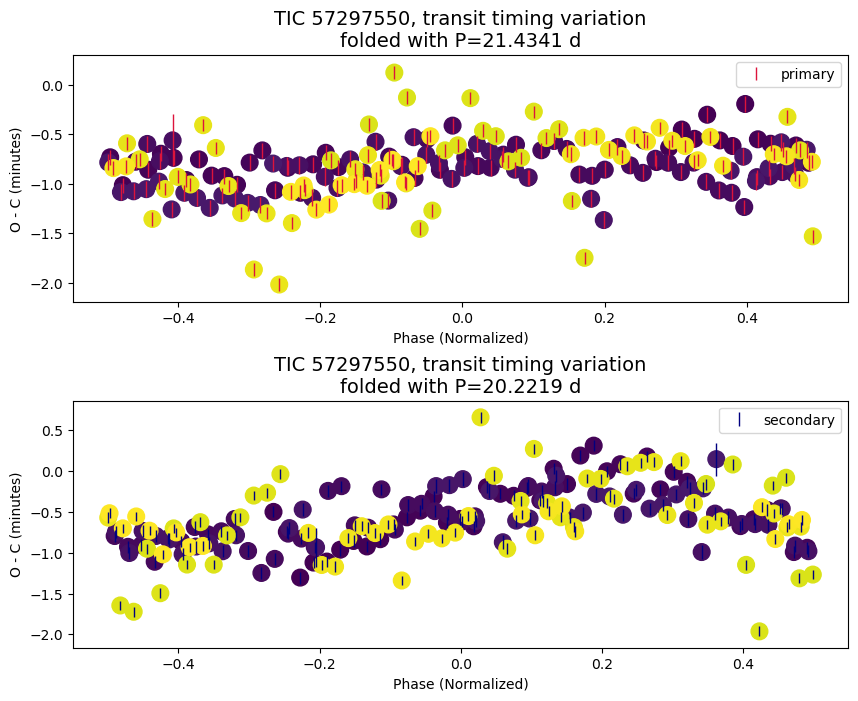

In [71]:
%matplotlib inline
# %matplotlib widget

if True:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    def tweak_axs(axs):
        pass

    axs = plot_oc_folded(
        period_min=None, period_max=100,
        period_min_s=None, period_max_s=100
    )
    tweak_axs(axs)

## Results Summary

In [73]:
# FILL-IN the ETV results / comments
has_etv = "Y?"
comments = "Mightbe long-term (~800 d) change  with ampltiude <3 min. The trend of primary is opposite of the one of secondary. Mightbe a O-C period of ~20 d. 2 sectors of 2min cadence + 2 sectors of 10min cadence. [D_no_ingress]"

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                                                                                                                                                                           57297550
has_etv                                                                                                                                                                                                                             Y?
comments     Mightbe long-term (~800 d) change  with ampltiude <3 min. The trend of primary is opposite of the one of secondary. Mightbe a O-C period of ~20 d. 2 sectors of 2min cadence + 2 sectors of 10min cadence. [D_no_ingress]
period                                                                                                                                                                                                                        0.382231
depth_pct_p                                                                                                                                                                                                                      15.12
depth_pct_s                                                                                                                                                                                                                      17.99
epoch_p                                                                                                                                                                                                                      1955.9667
epoch_s                                                                                                                                                                                                                    1956.157815
num_sectors                                                                                                                                                                                                                          4
time_span                                                                                                                                                                                                                       787.28
time_start                                                                                                                                                                                                                      1955.8
time_end                                                                                                                                                                                                                       2743.08


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
57297550,Y?,Mightbe long-term (~800 d) change  with ampltiude <3 min. The trend of primary is opposite of the one of secondary. Mightbe a O-C period of ~20 d. 2 sectors of 2min cadence + 2 sectors of 10min cadence. [D_no_ingress],0.38223062,15.12,17.99,1955.9667,1956.15781531,4,787.28,1955.8,2743.08

